<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/diffusion_emegence_rates_mini3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Emergent Rate
lofi alignment precursor study

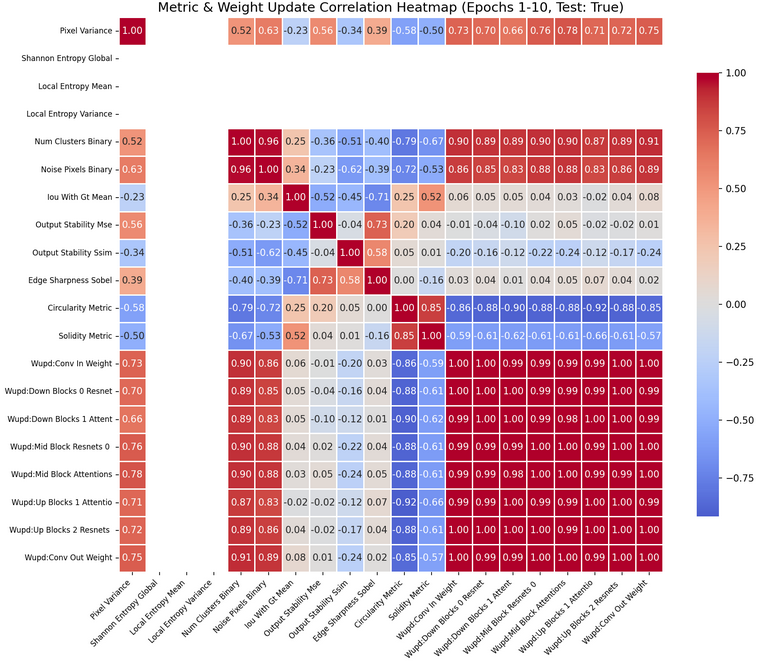

In [1]:
# cell 0: global configuration, imports, and seeds

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import yaml
import json
import os
import gc
from pathlib import Path
import random
import cv2
import torch
import torch.nn as nn
import skimage.measure
import skimage.metrics
import time

from torch.utils.data import Dataset, DataLoader

MASTER_SEED = 42
torch.manual_seed(MASTER_SEED)
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEST_MODE = True
IMAGE_SIZE = 16
MARGIN = 2
RENDERING_ANTI_ALIASED = False
SHARPNESS_TARGET = "aliased"

DIFFUSERS_IMPORT_SUCCESS = False
try:
    import diffusers
    CURRENT_DIFFUSERS_VERSION_STR = diffusers.__version__.replace('.', '_')
    DIFFUSERS_IMPORT_SUCCESS = True
except ImportError:
    CURRENT_DIFFUSERS_VERSION_STR = "INSTALL_FAILED"


EXPERIMENT_SUBFOLDER_NAME = f'run_img{IMAGE_SIZE}_{SHARPNESS_TARGET}_diffusers_{CURRENT_DIFFUSERS_VERSION_STR}_{time.strftime("%Y%m%d_%H%M%S")}'

PERSISTENT_SAVE_ROOT_ON_DRIVE = Path("./drive/MyDrive/diffusion_tests")
if 'PERSISTENT_SAVE_ROOT_ON_DRIVE' not in globals():
    print("critical error: PERSISTENT_SAVE_ROOT_ON_DRIVE not defined by cell 0.0. defaulting to local path.")
    PERSISTENT_SAVE_ROOT_ON_DRIVE = Path("./drive/MyDrive/diffusion_tests")

BASE_SAVE_DIR = PERSISTENT_SAVE_ROOT_ON_DRIVE / EXPERIMENT_SUBFOLDER_NAME


DATASET_DIR = BASE_SAVE_DIR / 'dataset/'
MODEL_CHECKPOINT_DIR = BASE_SAVE_DIR / 'model_checkpoints/'
RESULTS_LOG_DIR = BASE_SAVE_DIR / 'logs/'
VISUALIZATION_DIR = BASE_SAVE_DIR / 'visualizations/'
VIDEO_OUTPUT_DIR = BASE_SAVE_DIR / 'videos_ultimate/'

for dir_path in [BASE_SAVE_DIR, DATASET_DIR, MODEL_CHECKPOINT_DIR, RESULTS_LOG_DIR, VISUALIZATION_DIR, VIDEO_OUTPUT_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

if TEST_MODE:
    DATASET_NUM_SAMPLES_PER_COMPLEXITY_CLASS = 10
    DATASET_FORCE_REGENERATE = True
else:
    DATASET_NUM_SAMPLES_PER_COMPLEXITY_CLASS = 70
    DATASET_FORCE_REGENERATE = False

DATASET_FILE = DATASET_DIR / f'geometric_dataset_img{IMAGE_SIZE}_{SHARPNESS_TARGET}.pt'
DATASET_CONFIG_FILE = DATASET_DIR / f'dataset_config_img{IMAGE_SIZE}_{SHARPNESS_TARGET}.yaml'

SHAPE_CATALOG = {
    'circle': {'parameters': ['radius_ratio'], 'num_vertices': 0, 'base_complexity_score': 0.1},
    'square': {'parameters': ['size_ratio', 'rotation_angle'], 'num_vertices': 4, 'base_complexity_score': 0.2},
    'equilateral_triangle': {'parameters': ['size_ratio', 'rotation_angle'], 'num_vertices': 3, 'base_complexity_score': 0.3},
    'rectangle': {'parameters': ['width_ratio', 'height_ratio', 'rotation_angle'], 'num_vertices': 4, 'base_complexity_score': 0.4},
    'pentagon': {'parameters': ['size_ratio', 'rotation_angle'], 'num_vertices': 5, 'base_complexity_score': 0.6},
    'hexagon': {'parameters': ['size_ratio', 'rotation_angle'], 'num_vertices': 6, 'base_complexity_score': 0.7},
    'star_5_pointed': {'parameters': ['outer_radius_ratio', 'inner_radius_ratio', 'rotation_angle'], 'num_vertices': 10, 'base_complexity_score': 0.9}
}
SORTED_SHAPE_NAMES = sorted(SHAPE_CATALOG.keys(), key=lambda s: SHAPE_CATALOG[s]['base_complexity_score'])
CLASS_ID_TO_SHAPE_NAME = {i: name for i, name in enumerate(SORTED_SHAPE_NAMES)}
SHAPE_NAME_TO_CLASS_ID = {name: i for i, name in CLASS_ID_TO_SHAPE_NAME.items()}
for i, shape_name in CLASS_ID_TO_SHAPE_NAME.items(): SHAPE_CATALOG[shape_name]['class_id'] = i
NUM_SHAPE_CLASSES = len(SHAPE_CATALOG)

ENHANCED_METRIC_CONFIG = {
    'local_entropy_patch_size': (4, 4),
    'tracked_layers_for_weights': [
        'conv_in.weight',                                                 # 1. input convolution
        'down_blocks.0.resnets.0.conv1.weight',                           # 2. Early ResNet conv
        'down_blocks.1.attentions.0.to_q.weight',                         # 3. Downsampling attention
        'mid_block.resnets.0.conv1.weight',                               # 4. Mid-block ResNet conv
        'mid_block.attentions.0.transformer_blocks.0.attn1.to_k.weight',  # 5. Mid-block self-attention
        'up_blocks.1.attentions.0.to_k.weight',                           # 6. upsampling attention
        'up_blocks.2.resnets.1.conv2.weight',                             # 7. late ResNet conv
        'conv_out.weight'                                                 # 8. final output convolution
    ],
    'num_stability_samples_k': 3 if not TEST_MODE else 2,
    'noise_pixels_binary_threshold_area': 2,
}

EMERGENT_METRIC_KEYS = [
    'pixel_variance',
    'shannon_entropy_global',
    'local_entropy_mean',
    'local_entropy_variance',
    'num_clusters_binary',
    'noise_pixels_binary',
    'IoU_with_gt_mean',
    'output_stability_mse',
    'output_stability_ssim',
    'edge_sharpness_sobel',
    'circularity_metric',
    'solidity_metric',
]

TRAIN_NUM_EPOCHS_ULOFI_ = 400 if not TEST_MODE else 10
TRAIN_BATCH_SIZE_ULOFI_ = 32 if not TEST_MODE else 16
TRAIN_LEARNING_RATE_ = 5e-4
TRAIN_LR_WARMUP_STEPS_ULOFI_ = 50
TRAIN_GRADIENT_CLIP_NORM_ = 1.0

# early stoppign patience
early_stopping_patience = 50


# unet architecture params for cell 2
layers_per_block_unet_ = 2
block_out_channels_unet_ = (64, 128, 128)
cross_attention_dim_unet_ = 128
attention_head_dim_unet_ = 8

DATASET_BATCH_SIZE_ = TRAIN_BATCH_SIZE_ULOFI_
train_split_ratio_ = 0.70


# image rate
metrics_sample_freq = 1


MODEL_CHECKPOINT_FILE = MODEL_CHECKPOINT_DIR / f'unet_checkpoint_img{IMAGE_SIZE}_{SHARPNESS_TARGET}.pth'
TRAINING_HISTORY_FILE = RESULTS_LOG_DIR / f'training_history_img{IMAGE_SIZE}_{SHARPNESS_TARGET}.json'
_FIGURE_SAVE_NAME_MAIN_PLOT = f"learning_curves{'_testmode' if TEST_MODE else ''}.png"
_FIGURE_SAVE_NAME_METRICS_PLOT = f"emergent_metrics{'_testmode' if TEST_MODE else ''}.png"
_EXPERIMENT_TAG_NAME = f"ultralofi_img{IMAGE_SIZE}_{SHARPNESS_TARGET}_diffusers_{CURRENT_DIFFUSERS_VERSION_STR}"


--- dataset engine processing (test_mode: True) ---
generating new dataset (force_regenerate=True or file not found)...
generating 10 samples/class for 7 classes...
saving dataset to drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/dataset/geometric_dataset_img16_aliased.pt...
dataset config saved: /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/dataset/dataset_config_img16_aliased.yaml
train_size: 49, val_size: 21. batch_size: 16

--- visualizing a few dataset samples ---


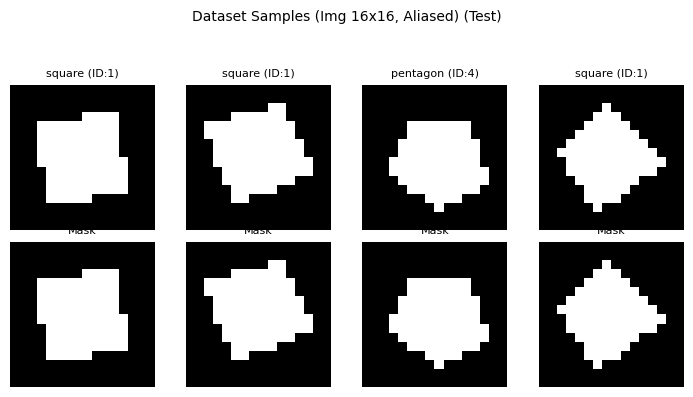

In [2]:
# cell 1: dataset engine - shape renderer, synthetic dataset, dataloaders

class ShapeRenderer:
    def __init__(self, image_size, margin, anti_aliased_default=False):
        self.image_size = image_size
        self.margin = margin
        self.drawable_size = image_size - 2 * margin
        self.anti_aliased_default = anti_aliased_default
        if self.drawable_size <= 0:
            raise ValueError(f"image_size ({image_size}) too small for margin ({2*margin})")

    def _finalize_image_and_mask(self, rendered_on_drawable_area_np):
        final_image_arr = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        paste_x_start, paste_y_start = self.margin, self.margin
        paste_x_end = paste_x_start + self.drawable_size
        paste_y_end = paste_y_start + self.drawable_size
        h, w = rendered_on_drawable_area_np.shape
        final_image_arr[paste_y_start:paste_y_end, paste_x_start:paste_x_end] = rendered_on_drawable_area_np[:self.drawable_size, :self.drawable_size]
        mask_arr = (final_image_arr > 128).astype(np.uint8)
        return final_image_arr, mask_arr

    def _calculate_polygon_vertices(self, center_x, center_y, num_vertices, size_pixels, rotation_angle_deg):
        vertices = []
        angle_step = 2 * np.pi / num_vertices
        rotation_rad = np.deg2rad(rotation_angle_deg)
        for i in range(num_vertices):
            angle = i * angle_step + rotation_rad
            x = int(round(center_x + size_pixels * np.cos(angle)))
            y = int(round(center_y + size_pixels * np.sin(angle)))
            x = max(0, min(x, self.drawable_size - 1))
            y = max(0, min(y, self.drawable_size - 1))
            vertices.append((x, y))
        return vertices

    def _calculate_star_vertices(self, center_x, center_y, outer_r_pixels, inner_r_pixels, num_points, rotation_angle_deg):
        vertices = []
        total_vertices = num_points * 2
        angle_step = 2 * np.pi / total_vertices
        rotation_rad = np.deg2rad(rotation_angle_deg)
        for i in range(total_vertices):
            radius = outer_r_pixels if i % 2 == 0 else inner_r_pixels
            angle = i * angle_step + rotation_rad
            x = int(round(center_x + radius * np.cos(angle)))
            y = int(round(center_y + radius * np.sin(angle)))
            x = max(0, min(x, self.drawable_size - 1)) # clip
            y = max(0, min(y, self.drawable_size - 1))
            vertices.append((x,y))
        return vertices

    def render_shape(self, shape_type, parameters, anti_aliased=None):
        if anti_aliased is None: anti_aliased = self.anti_aliased_default
        if anti_aliased: print(f"warning: anti-aliased rendering requested but cv2 path is aliased.")

        cx_drawable, cy_drawable = int(round(parameters['center_x'])), int(round(parameters['center_y']))
        cv2_canvas = np.zeros((self.drawable_size, self.drawable_size), dtype=np.uint8)

        if shape_type == 'circle':
            r_pixels = max(1, int(round(parameters['radius_ratio'] * (self.drawable_size / 2.0))))
            cv2.circle(cv2_canvas, (cx_drawable, cy_drawable), r_pixels, 255, -1)
        elif shape_type == 'square':
            side_len = max(2, parameters['size_ratio'] * self.drawable_size)
            angle_deg = parameters['rotation_angle']
            s_half = side_len / 2.0; angle_rad = np.deg2rad(angle_deg); cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
            v_rel = np.array([[-s_half,-s_half],[s_half,-s_half],[s_half,s_half],[-s_half,s_half]])
            rot_m = np.array([[cos_a,-sin_a],[sin_a,cos_a]])
            final_v = np.clip((v_rel @ rot_m.T + np.array([cx_drawable,cy_drawable])),0,self.drawable_size-1).astype(np.int32)
            if len(final_v)==4: cv2.fillPoly(cv2_canvas, [final_v], 255)
        elif shape_type == 'equilateral_triangle':
            circum_r = max(2, parameters['size_ratio'] * (self.drawable_size / 2.0))
            verts = self._calculate_polygon_vertices(cx_drawable,cy_drawable,3,circum_r,parameters['rotation_angle'])
            cv2.fillPoly(cv2_canvas, [np.array(verts, dtype=np.int32)], 255)
        elif shape_type == 'rectangle':
            w_px = max(2, parameters['width_ratio'] * self.drawable_size); h_px = max(2, parameters['height_ratio'] * self.drawable_size)
            angle_deg = parameters['rotation_angle']
            w_h,h_h = w_px/2.0,h_px/2.0; angle_rad=np.deg2rad(angle_deg); cos_a,sin_a=np.cos(angle_rad),np.sin(angle_rad)
            v_rel=np.array([[-w_h,-h_h],[w_h,-h_h],[w_h,h_h],[-w_h,h_h]])
            rot_m=np.array([[cos_a,-sin_a],[sin_a,cos_a]])
            final_v=np.clip((v_rel @ rot_m.T + np.array([cx_drawable,cy_drawable])),0,self.drawable_size-1).astype(np.int32)
            if len(final_v)==4: cv2.fillPoly(cv2_canvas, [final_v], 255)
        elif shape_type in ['pentagon', 'hexagon']:
            num_v = SHAPE_CATALOG[shape_type]['num_vertices']
            circum_r = max(2, parameters['size_ratio'] * (self.drawable_size / 2.0))
            verts = self._calculate_polygon_vertices(cx_drawable,cy_drawable,num_v,circum_r,parameters['rotation_angle'])
            cv2.fillPoly(cv2_canvas, [np.array(verts, dtype=np.int32)], 255)
        elif shape_type == 'star_5_pointed':
            out_r = max(3, parameters['outer_radius_ratio'] * (self.drawable_size/2.0))
            in_r = max(1, parameters['inner_radius_ratio'] * (self.drawable_size/2.0))
            if in_r >= out_r: in_r = out_r * 0.4
            verts = self._calculate_star_vertices(cx_drawable,cy_drawable,out_r,in_r,5,parameters['rotation_angle'])
            cv2.fillPoly(cv2_canvas, [np.array(verts, dtype=np.int32)], 255)
        else:
            raise ValueError(f"unsupported shape_type for cv2 rendering: {shape_type}")
        return self._finalize_image_and_mask(cv2_canvas)

class SyntheticGeometricDataset(Dataset):
    def __init__(self, num_samples_per_class, image_size, margin, shape_catalog_dict, renderer_instance,
                 anti_aliased_flag, dataset_file_path_obj, force_regenerate_flag):
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size
        self.margin = margin
        self.drawable_size = image_size - 2 * margin
        self.shape_catalog = shape_catalog_dict
        self.renderer = renderer_instance
        self.anti_aliased = anti_aliased_flag
        self.dataset_file_path = dataset_file_path_obj
        self.samples = []

        if self.dataset_file_path and self.dataset_file_path.exists() and not force_regenerate_flag:
            print(f"loading dataset from {self.dataset_file_path}...")
            self._load_dataset()
        else:
            print(f"generating new dataset (force_regenerate={force_regenerate_flag} or file not found)...")
            self._generate_samples()
            if self.dataset_file_path: self._save_dataset()

    def _generate_random_params_for_shape(self, shape_name_str, shape_type_info_dict):
        params = {}
        center_coord = self.drawable_size / 2.0
        max_abs_jitter = 0.5 if self.drawable_size <= 4 else 1.0 if self.drawable_size < 10 else 1.5
        params['center_x'] = center_coord + random.uniform(-max_abs_jitter, max_abs_jitter)
        params['center_y'] = center_coord + random.uniform(-max_abs_jitter, max_abs_jitter)

        large_scale_min, large_scale_max = (0.80, 0.98) if self.drawable_size >= 8 else (0.85, 1.0)

        if 'radius_ratio' in shape_type_info_dict['parameters']:
            params['radius_ratio'] = random.uniform(large_scale_min, large_scale_max)
        if 'size_ratio' in shape_type_info_dict['parameters']:
            params['size_ratio'] = random.uniform(large_scale_min * (0.8 if shape_name_str=='square' else 1.0) , large_scale_max)
        if 'rotation_angle' in shape_type_info_dict['parameters']:
            params['rotation_angle'] = random.uniform(0, 359.9)
        if shape_name_str == 'rectangle':
            is_w_dom = random.choice([True, False])
            min_dim_ratio = 2.0 / self.drawable_size
            params['width_ratio'] = random.uniform(0.6,0.9) if is_w_dom else random.uniform(max(min_dim_ratio,0.3*random.uniform(0.6,0.9)),0.5*random.uniform(0.6,0.9))
            params['height_ratio'] = random.uniform(max(min_dim_ratio,0.3*params['width_ratio']),0.5*params['width_ratio']) if is_w_dom else random.uniform(0.6,0.9)
            if not is_w_dom: params['width_ratio'], params['height_ratio'] = params['height_ratio'], params['width_ratio']
        if shape_name_str == 'star_5_pointed':
            params['outer_radius_ratio'] = random.uniform(large_scale_min, large_scale_max)
            params['inner_radius_ratio'] = random.uniform(params['outer_radius_ratio']*0.35, params['outer_radius_ratio']*0.60)
        return params

    def _generate_samples(self):
        self.samples = []
        print(f"generating {self.num_samples_per_class} samples/class for {len(self.shape_catalog)} classes...")
        for shape_name, shape_info in self.shape_catalog.items():
            for _ in range(self.num_samples_per_class):
                params = self._generate_random_params_for_shape(shape_name, shape_info)
                try:
                    img_np, mask_np = self.renderer.render_shape(shape_name, params, self.anti_aliased)
                    self.samples.append({
                        'image': torch.from_numpy(img_np.astype(np.float32)).unsqueeze(0),
                        'mask': torch.from_numpy(mask_np.astype(np.float32)).unsqueeze(0),
                        'shape_type': shape_name, 'class_id': shape_info['class_id'],
                        'parameters': params, 'base_complexity_score': shape_info['base_complexity_score']
                    })
                except Exception as e: print(f"error rendering {shape_name} with {params}: {e}")
        random.shuffle(self.samples)

    def _save_dataset(self):
        print(f"saving dataset to {self.dataset_file_path}...")
        self.dataset_file_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(self.samples, self.dataset_file_path)

    def _load_dataset(self):
        self.samples = torch.load(self.dataset_file_path)

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            'image': sample['image'] / 255.0, 'mask': sample['mask'],
            'class_id': torch.tensor(sample['class_id'], dtype=torch.long),
            'shape_type': sample['shape_type'],
            'base_complexity_score': sample['base_complexity_score']
        }


print(f"\n--- dataset engine processing (test_mode: {TEST_MODE}) ---")
shape_renderer_instance = ShapeRenderer(
    image_size=IMAGE_SIZE, margin=MARGIN, anti_aliased_default=RENDERING_ANTI_ALIASED
)
geometric_dataset = SyntheticGeometricDataset(
    num_samples_per_class=DATASET_NUM_SAMPLES_PER_COMPLEXITY_CLASS,
    image_size=IMAGE_SIZE, margin=MARGIN, shape_catalog_dict=SHAPE_CATALOG,
    renderer_instance=shape_renderer_instance, anti_aliased_flag=RENDERING_ANTI_ALIASED,
    dataset_file_path_obj=DATASET_FILE, force_regenerate_flag=DATASET_FORCE_REGENERATE
)

dataset_config_output = {
    'master_seed': MASTER_SEED, 'image_size': IMAGE_SIZE, 'margin': MARGIN,
    'rendering_anti_aliased': RENDERING_ANTI_ALIASED,
    'num_requested_samples_per_class': DATASET_NUM_SAMPLES_PER_COMPLEXITY_CLASS,
    'actual_num_samples_generated': len(geometric_dataset),
    'num_shape_classes': NUM_SHAPE_CLASSES,
    'dataset_file_used': str(DATASET_FILE.resolve() if DATASET_FILE.exists() else DATASET_FILE),
    'dataset_strategy': "ultra-lofi blocky & bound",
    'generation_timestamp_utc': time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    'shape_catalog_snapshot': {k: {**v, 'class_id': int(v['class_id'])} for k, v in SHAPE_CATALOG.items()}
}
try:
    with open(DATASET_CONFIG_FILE, 'w') as f: yaml.dump(dataset_config_output, f, indent=2, sort_keys=False)
    print(f"dataset config saved: {DATASET_CONFIG_FILE.resolve()}")
except Exception as e: print(f"error saving dataset config: {e}")


train_dataloader, val_dataloader = None, None
if len(geometric_dataset) > 0:
    val_size = max(1, int(len(geometric_dataset) * (1.0 - train_split_ratio_))) if len(geometric_dataset) > 1 else 0
    train_size = len(geometric_dataset) - val_size

    if train_size > 0 and val_size > 0 :
        generator = torch.Generator().manual_seed(MASTER_SEED)
        train_dataset, val_dataset = torch.utils.data.random_split(geometric_dataset, [train_size, val_size], generator=generator)
        num_workers = 0
        train_dataloader = DataLoader(train_dataset, batch_size=DATASET_BATCH_SIZE_, shuffle=True, num_workers=num_workers, pin_memory=(DEVICE.type == 'cuda'))
        val_dataloader = DataLoader(val_dataset, batch_size=DATASET_BATCH_SIZE_, shuffle=False, num_workers=num_workers, pin_memory=(DEVICE.type == 'cuda'))
        print(f"train_size: {len(train_dataset)}, val_size: {len(val_dataset)}. batch_size: {DATASET_BATCH_SIZE_}")
    else: print(f"error: not enough data for train/val split. total: {len(geometric_dataset)}")
else: print("error: geometric_dataset is empty.")


if train_dataloader and len(train_dataloader.dataset) > 0 and 'matplotlib' in sys.modules:
    print(f"\n--- visualizing a few dataset samples ---")
    try:
        sample_batch = next(iter(train_dataloader))
        num_display = min(sample_batch['image'].size(0), 4)
        fig, axes = plt.subplots(2, num_display, figsize=(num_display * 1.8, 4.0))
        if num_display == 1: axes_flat = [axes[0], axes[1]]
        else: axes_flat = axes.T.flatten()
        fig.suptitle(f"Dataset Samples (Img {IMAGE_SIZE}x{IMAGE_SIZE}, Aliased){' (Test)' if TEST_MODE else ''}", fontsize=10)
        for i in range(num_display):
            img, mask, cid = sample_batch['image'][i],sample_batch['mask'][i],sample_batch['class_id'][i].item()
            sname = CLASS_ID_TO_SHAPE_NAME.get(cid, "Unk")[:10]
            ax_img, ax_mask = (axes[0,i], axes[1,i]) if num_display > 1 else (axes_flat[0], axes_flat[1])
            ax_img.imshow(img.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
            ax_img.set_title(f"{sname} (ID:{cid})", fontsize=8); ax_img.axis('off')
            ax_mask.imshow(mask.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
            ax_mask.set_title(f"Mask", fontsize=8); ax_mask.axis('off')
        plt.tight_layout(rect=[0,0,1,0.92]); plt.show()
    except Exception as e: print(f"error during visualization: {e}")
else: print("train_dataloader not available or matplotlib not imported for visualization.")

In [3]:
# cell 2: model and training configuration

from diffusers import UNet2DConditionModel, DDPMScheduler, DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch.optim as optim

print(f"--- unet model configuration (test_mode: {TEST_MODE}) ---")

if IMAGE_SIZE != 16:
    raise ValueError("IMAGE_SIZE from cell 0 must be 16 for 'ultra-lofi' setup.")
if 'NUM_SHAPE_CLASSES' not in globals() or NUM_SHAPE_CLASSES <= 0:
    raise ValueError("NUM_SHAPE_CLASSES from cell 0 is not defined or invalid.")
print(f"  input image_size: {IMAGE_SIZE}x{IMAGE_SIZE}, num_classes for conditioning: {NUM_SHAPE_CLASSES}")

# unet configuration dictionary
unet_config = {
    'sample_size': IMAGE_SIZE,
    'in_channels': 1,
    'out_channels': 1,
    'layers_per_block': layers_per_block_unet_,
    'block_out_channels': block_out_channels_unet_,
    'down_block_types': (
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    'up_block_types': (
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
    'cross_attention_dim': cross_attention_dim_unet_,
    'num_class_embeds': NUM_SHAPE_CLASSES,
    'attention_head_dim': attention_head_dim_unet_,
}

unet = UNet2DConditionModel(**unet_config).to(DEVICE)
model_parameters = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"unet model initialized on {DEVICE}. trainable parameters: {model_parameters:,}")

# --- utility to print layer names for weight tracking configuration ---
print("\n--- model layer names for weight tracking configuration ---")
print("instructions: copy relevant layer names (those ending in '.weight') from the list below.")
print("paste them into the 'ENHANCED_METRIC_CONFIG['tracked_layers_for_weights']' list in cell 0.")
print("after updating cell 0, re-run cell 0, then re-run this cell (cell 2) before proceeding to cell 3.")
print("-" * 30)
for name, param in unet.named_parameters():
    if name.endswith(".weight"):
        print(f"  '{name}' (shape: {list(param.shape)})")
print("-" * 30)

# --- scheduler definitions ---
ddpm_train_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule='linear',
    prediction_type='epsilon'
)

ddim_inference_scheduler = DDIMScheduler.from_config(ddpm_train_scheduler.config)
print(f"\nddpm train scheduler ({ddpm_train_scheduler.config.num_train_timesteps} steps) and ddim inference scheduler initialized.")

# --- training configuration---
num_epochs = TRAIN_NUM_EPOCHS_ULOFI_
training_batch_size = TRAIN_BATCH_SIZE_ULOFI_
learning_rate = TRAIN_LEARNING_RATE_
lr_warmup_steps_config = TRAIN_LR_WARMUP_STEPS_ULOFI_
gradient_clip_norm = TRAIN_GRADIENT_CLIP_NORM_

print(f"\n--- training hyperparameters (test_mode: {TEST_MODE}) ---")
print(f"  batch_size (for training): {training_batch_size}")
print(f"  num_epochs: {num_epochs}")
print(f"  learning_rate: {learning_rate}")
print(f"  lr_warmup_steps (config): {lr_warmup_steps_config}")
print(f"  gradient_clip_norm: {gradient_clip_norm}")

# --- optimizer & learning rate scheduler ---
if 'train_dataloader' in globals() and train_dataloader is not None and len(train_dataloader) > 0:
    optimizer = optim.AdamW(unet.parameters(), lr=learning_rate, weight_decay=1e-2)

    num_update_steps_per_epoch = len(train_dataloader)
    max_train_steps = num_epochs * num_update_steps_per_epoch

    actual_lr_warmup_steps = lr_warmup_steps_config
    if lr_warmup_steps_config >= max_train_steps / 2 and max_train_steps > 0:
        actual_lr_warmup_steps = max(1, int(max_train_steps * 0.1))
        print(f"info: lr_warmup_steps ({lr_warmup_steps_config}) was high for max_train_steps ({max_train_steps}). adjusted to {actual_lr_warmup_steps}.")

    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=actual_lr_warmup_steps,
        num_training_steps=max_train_steps,
    )
    print(f"optimizer (adamw) and lr_scheduler (cosine with {actual_lr_warmup_steps} warmup steps) initialized.")
    print(f"  max_train_steps for lr_scheduler: {max_train_steps}")
    if max_train_steps == 0:
        print("warning: max_train_steps is 0. lr_scheduler may not step. check dataloader and epochs.")
else:
    optimizer = None
    lr_scheduler = None
    max_train_steps = 0
    print(f"error: train_dataloader from cell 1 not available or empty. optimizer/lr_scheduler cannot be fully created.")
    print(f"  please re-run cell 1 successfully to create 'train_dataloader'.")

# --- variable for weight update tracking in cell 3 ---
previous_unet_state_dict = None

print(f"\n--- cell 2 model & training config complete (test_mode: {TEST_MODE}) ---")
if optimizer is None:
    print("critical warning: optimizer is None. training cannot proceed. check train_dataloader in cell 1.")
else:
    print("optimizer and scheduler setup appears successful.")

--- unet model configuration (test_mode: True) ---
  input image_size: 16x16, num_classes for conditioning: 7
unet model initialized on cpu. trainable parameters: 6,768,513

--- model layer names for weight tracking configuration ---
instructions: copy relevant layer names (those ending in '.weight') from the list below.
paste them into the 'ENHANCED_METRIC_CONFIG['tracked_layers_for_weights']' list in cell 0.
after updating cell 0, re-run cell 0, then re-run this cell (cell 2) before proceeding to cell 3.
------------------------------
  'conv_in.weight' (shape: [64, 1, 3, 3])
  'time_embedding.linear_1.weight' (shape: [256, 64])
  'time_embedding.linear_2.weight' (shape: [256, 256])
  'class_embedding.weight' (shape: [7, 256])
  'down_blocks.0.resnets.0.norm1.weight' (shape: [64])
  'down_blocks.0.resnets.0.conv1.weight' (shape: [64, 64, 3, 3])
  'down_blocks.0.resnets.0.time_emb_proj.weight' (shape: [64, 256])
  'down_blocks.0.resnets.0.norm2.weight' (shape: [64])
  'down_blocks.0.r

  device: cpu, target epochs: 10

starting training for 10 epochs on cpu...


epoch 001/10 | dur:   5.06s | tr_loss: 0.90186 | vl_loss: 0.30339 | lr: 5.0e-04
  -> val_loss improved to 0.30339. model saved to unet_checkpoint_img16_aliased.pth
  generating samples & calculating metrics (epoch 1, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:9.00, binary:4.00, mean:0.20, mse:0.04, ssim:-0.04, sobel:135.05, metric:0.05, metric:0.27


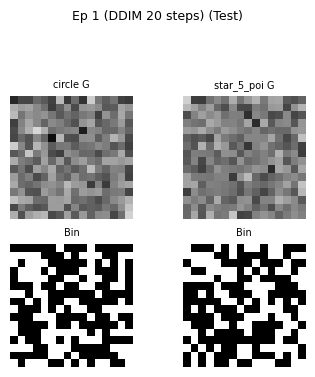

epoch 002/10 | dur:   4.45s | tr_loss: 0.36338 | vl_loss: 0.33257 | lr: 4.8e-04
  generating samples & calculating metrics (epoch 2, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:8.00, binary:5.00, mean:0.22, mse:0.05, ssim:-0.07, sobel:135.42, metric:0.07, metric:0.53


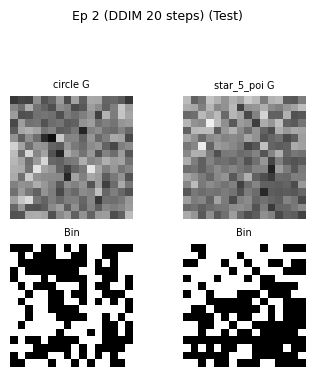

epoch 003/10 | dur:   3.90s | tr_loss: 0.20323 | vl_loss: 0.17552 | lr: 4.4e-04
  -> val_loss improved to 0.17552. model saved to unet_checkpoint_img16_aliased.pth
  generating samples & calculating metrics (epoch 3, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:2.50, binary:0.50, mean:0.16, mse:0.05, ssim:0.02, sobel:146.18, metric:0.03, metric:0.34


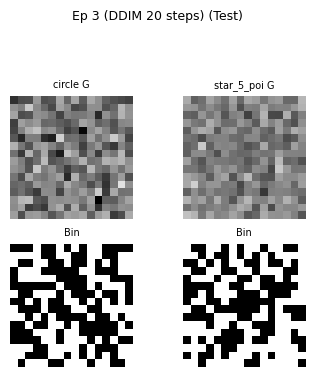

epoch 004/10 | dur:   4.27s | tr_loss: 0.28478 | vl_loss: 0.29562 | lr: 3.8e-04
  generating samples & calculating metrics (epoch 4, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:4.50, binary:1.50, mean:0.22, mse:0.03, ssim:0.00, sobel:130.88, metric:0.10, metric:0.56


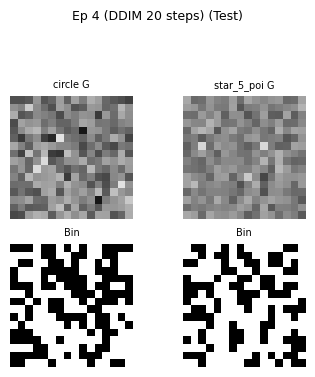

epoch 005/10 | dur:   4.35s | tr_loss: 0.15966 | vl_loss: 0.20074 | lr: 2.9e-04
  generating samples & calculating metrics (epoch 5, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:1.50, mean:0.21, mse:0.05, ssim:0.03, sobel:142.95, metric:0.23, metric:0.63


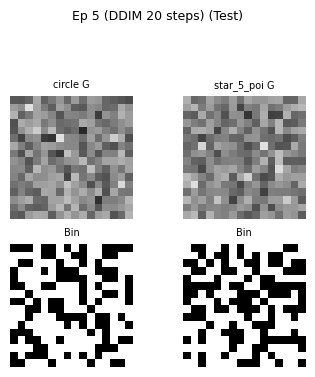

epoch 006/10 | dur:   3.80s | tr_loss: 0.16189 | vl_loss: 0.19778 | lr: 2.1e-04
  generating samples & calculating metrics (epoch 6, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:2.50, mean:0.19, mse:0.04, ssim:-0.02, sobel:137.31, metric:0.20, metric:0.52


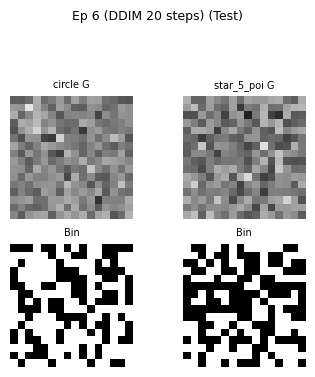

epoch 007/10 | dur:   4.47s | tr_loss: 0.13292 | vl_loss: 0.11541 | lr: 1.3e-04
  -> val_loss improved to 0.11541. model saved to unet_checkpoint_img16_aliased.pth
  generating samples & calculating metrics (epoch 7, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:1.00, mean:0.20, mse:0.05, ssim:-0.02, sobel:135.43, metric:0.27, metric:0.64


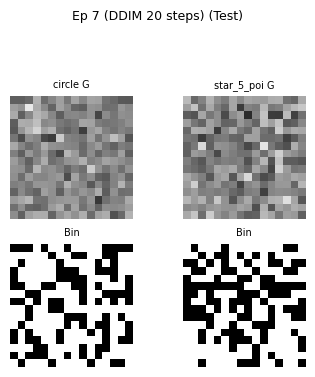

epoch 008/10 | dur:   4.40s | tr_loss: 0.16360 | vl_loss: 0.11468 | lr: 5.8e-05
  -> val_loss improved to 0.11468. model saved to unet_checkpoint_img16_aliased.pth
  generating samples & calculating metrics (epoch 8, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:1.00, mean:0.20, mse:0.05, ssim:-0.02, sobel:137.04, metric:0.26, metric:0.68


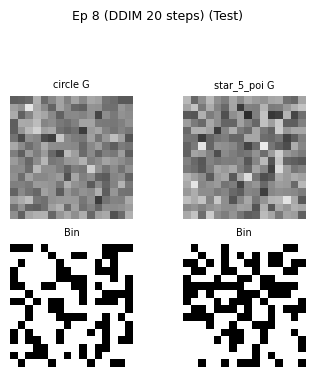

epoch 009/10 | dur:   3.87s | tr_loss: 0.20335 | vl_loss: 0.09971 | lr: 1.5e-05
  -> val_loss improved to 0.09971. model saved to unet_checkpoint_img16_aliased.pth
  generating samples & calculating metrics (epoch 9, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:1.00, mean:0.20, mse:0.05, ssim:-0.02, sobel:138.27, metric:0.25, metric:0.64


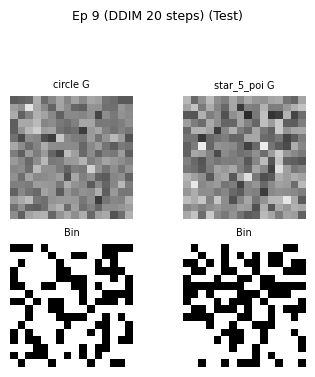

epoch 010/10 | dur:   4.37s | tr_loss: 0.11770 | vl_loss: 0.15812 | lr: 0.0e+00
  generating samples & calculating metrics (epoch 10, ddim 20 steps)...
  img_metrics: varian:0.02, global:8.00, mean:4.00, binary:1.00, mean:0.20, mse:0.05, ssim:-0.02, sobel:138.66, metric:0.25, metric:0.60


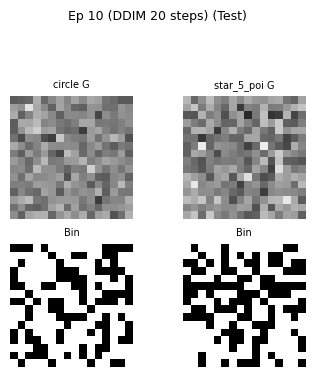


--- training complete (test_mode: True) ---
total training duration: 1.46 min
best validation loss: 0.09971
training history saved to /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/logs/training_history_img16_aliased.json

--- cell 3 training engine complete (test_mode: True) ---


In [4]:
# cell 3: training engine - loop, validation, checkpointing & enhanced emergent metrics

import torch
import torch.nn as nn
from tqdm import tqdm #
import copy

if 'unet' not in globals() or 'ddpm_train_scheduler' not in globals() or 'optimizer' not in globals():
    raise RuntimeError("unet, schedulers, or optimizer not found. ensure cells 0, 1, 2 ran successfully.")
else:
    print(f"  device: {DEVICE}, target epochs: {TRAIN_NUM_EPOCHS_ULOFI_}")



def convert_numpy_types_to_native(obj):
    if isinstance(obj, dict): return {k: convert_numpy_types_to_native(v) for k, v in obj.items()}
    if isinstance(obj, list): return [convert_numpy_types_to_native(elem) for elem in obj]
    if isinstance(obj, np.integer): return int(obj)
    if isinstance(obj, np.floating): return float(obj)
    if isinstance(obj, np.ndarray): return convert_numpy_types_to_native(obj.tolist())
    return obj

def calculate_pixel_variance(grayscale_image_np):
    return np.var(grayscale_image_np) if grayscale_image_np is not None and grayscale_image_np.size > 0 else 0.0

def calculate_shannon_entropy_global(grayscale_image_np):
    if grayscale_image_np is None or grayscale_image_np.size == 0: return 0.0
    min_val, max_val = np.min(grayscale_image_np), np.max(grayscale_image_np)
    if max_val == min_val: return 0.0
    img_norm = (grayscale_image_np - min_val) / (max_val - min_val)
    return skimage.measure.shannon_entropy(img_norm)

def calculate_local_shannon_entropy(grayscale_image_np, patch_size_tuple):
    if grayscale_image_np is None or grayscale_image_np.size == 0: return 0.0, 0.0
    h, w = grayscale_image_np.shape
    ph, pw = patch_size_tuple
    patch_entropies = []
    for i in range(0, h - ph + 1, ph):
        for j in range(0, w - pw + 1, pw):
            patch = grayscale_image_np[i:i+ph, j:j+pw]
            if patch.size > 0:
                min_val, max_val = np.min(patch), np.max(patch)
                if max_val == min_val: patch_entropy = 0.0
                else:
                    patch_norm = (patch - min_val) / (max_val - min_val)
                    patch_entropy = skimage.measure.shannon_entropy(patch_norm)
                patch_entropies.append(patch_entropy)
    if not patch_entropies: return 0.0, 0.0
    return np.mean(patch_entropies), np.var(patch_entropies)

def calculate_num_clusters_binary(binary_image_np):
    if binary_image_np is None or binary_image_np.size == 0: return 0
    binary_u8 = (binary_image_np.clip(0,1) * 255).astype(np.uint8)
    num_labels, _, _, _ = cv2.connectedComponentsWithStats(binary_u8, connectivity=8)
    return num_labels - 1

def calculate_noise_pixels_binary(binary_image_np, noise_threshold_area):
    if binary_image_np is None or binary_image_np.size == 0: return 0
    binary_u8 = (binary_image_np.clip(0,1) * 255).astype(np.uint8)
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary_u8, connectivity=8)
    if num_labels <= 1: return 0
    noise_count = np.sum(stats[1:, cv2.CC_STAT_AREA] <= noise_threshold_area)
    return int(noise_count)

def calculate_iou_with_gt(binary_pred_np, binary_gt_np):
    if binary_pred_np is None or binary_gt_np is None or binary_pred_np.shape != binary_gt_np.shape: return 0.0
    intersection = np.logical_and(binary_pred_np, binary_gt_np).sum()
    union = np.logical_or(binary_pred_np, binary_gt_np).sum()
    if union == 0: return 1.0 if intersection == 0 else 0.0
    return intersection / union

def calculate_output_stability_pair(img1_gray_np, img2_gray_np):
    if img1_gray_np is None or img2_gray_np is None or img1_gray_np.shape != img2_gray_np.shape: return 0.0, 0.0
    mse = np.mean((img1_gray_np - img2_gray_np)**2)
    data_range = np.max(img1_gray_np) - np.min(img1_gray_np)
    if data_range < 1e-6: data_range = 1.0
    min_dim = min(img1_gray_np.shape[0], img1_gray_np.shape[1])
    win_size = min(5, min_dim)
    if win_size % 2 == 0: win_size -= 1
    if win_size < 1: win_size = 1

    ssim = 0.0
    if win_size >= 1 and win_size <= min_dim:
        try:
            ssim = skimage.metrics.structural_similarity(
                img1_gray_np, img2_gray_np, data_range=data_range,
                channel_axis=None, win_size=win_size
            )
        except ValueError: ssim = 0.0
    return mse, ssim

def calculate_edge_sharpness_sobel(grayscale_image_np):
    if grayscale_image_np is None or grayscale_image_np.size == 0: return 0.0
    img_u8 = (grayscale_image_np.clip(0,1) * 255).astype(np.uint8)
    k_size = 3 if min(img_u8.shape) >=3 else 1
    sobelx = cv2.Sobel(img_u8, cv2.CV_64F, 1, 0, ksize=k_size)
    sobely = cv2.Sobel(img_u8, cv2.CV_64F, 0, 1, ksize=k_size)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    return np.mean(magnitude)

def calculate_contour_metrics(binary_image_np):
    if binary_image_np is None or binary_image_np.size == 0: return 0.0, 0.0
    binary_u8 = (binary_image_np.clip(0,1) * 255).astype(np.uint8)
    contours, _ = cv2.findContours(binary_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return 0.0, 0.0
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    if area < 1e-6: return 0.0, 0.0
    perimeter = cv2.arcLength(largest_contour, True)
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 1e-6 else 0.0
    hull = cv2.convexHull(largest_contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 1e-6 else 0.0
    return circularity, solidity

# --- 3.2: qualitative sampling & all metric calculation ---
@torch.no_grad()
def sample_and_calc_metrics(
    model_to_sample, sampling_scheduler, class_ids_list, gt_masks_list_np,
    num_inference_steps_sample=30, image_size_val=IMAGE_SIZE, device_val=DEVICE,
    seed_offset_base=3000, cfg=ENHANCED_METRIC_CONFIG
    ):
    model_to_sample.eval()
    num_unique_classes = len(class_ids_list)
    if num_unique_classes == 0: return [], [], {}

    # generate initial latents for main samples
    latents_main = torch.randn(
        (num_unique_classes, model_to_sample.config.in_channels, image_size_val, image_size_val),
        device=device_val, generator=torch.Generator(device=device_val).manual_seed(MASTER_SEED + seed_offset_base)
    )
    class_labels_tensor_main = torch.tensor(class_ids_list, device=device_val, dtype=torch.long)

    sampling_scheduler.set_timesteps(num_inference_steps_sample)
    current_latents_main = latents_main.clone()
    for t_val in sampling_scheduler.timesteps:
        model_output = model_to_sample(sample=current_latents_main, timestep=t_val, encoder_hidden_states=None, class_labels=class_labels_tensor_main).sample
        current_latents_main = sampling_scheduler.step(model_output, t_val, current_latents_main).prev_sample

    # post-process images: scale from [-1,1] to [0,1] and binarize
    images_gray_main = (current_latents_main / 2 + 0.5).clamp(0, 1)
    images_binary_main = (images_gray_main > 0.5).float()

    # convert to numpy for metric calculations
    images_gray_main_np = images_gray_main.cpu().permute(0, 2, 3, 1).squeeze(-1).numpy()
    images_binary_main_np = images_binary_main.cpu().permute(0, 2, 3, 1).squeeze(-1).numpy()

    # accumulator for metrics, initialized for all expected keys
    epoch_metrics_accumulator = {key: [] for key in EMERGENT_METRIC_KEYS if not key.startswith("w_update_")}

    for i in range(num_unique_classes):
        gray_np, binary_np = images_gray_main_np[i], images_binary_main_np[i]
        gt_mask_np = gt_masks_list_np[i] if gt_masks_list_np is not None and i < len(gt_masks_list_np) else None
        class_id = class_ids_list[i]

        if 'pixel_variance' in epoch_metrics_accumulator:
            epoch_metrics_accumulator['pixel_variance'].append(calculate_pixel_variance(gray_np))
        if 'shannon_entropy_global' in epoch_metrics_accumulator:
            epoch_metrics_accumulator['shannon_entropy_global'].append(calculate_shannon_entropy_global(gray_np))
        if 'local_entropy_mean' in epoch_metrics_accumulator and 'local_entropy_variance' in epoch_metrics_accumulator:
            le_mean, le_var = calculate_local_shannon_entropy(gray_np, cfg['local_entropy_patch_size'])
            epoch_metrics_accumulator['local_entropy_mean'].append(le_mean)
            epoch_metrics_accumulator['local_entropy_variance'].append(le_var)
        if 'num_clusters_binary' in epoch_metrics_accumulator:
            epoch_metrics_accumulator['num_clusters_binary'].append(calculate_num_clusters_binary(binary_np))
        if 'noise_pixels_binary' in epoch_metrics_accumulator:
            epoch_metrics_accumulator['noise_pixels_binary'].append(calculate_noise_pixels_binary(binary_np, cfg['noise_pixels_binary_threshold_area']))
        if 'IoU_with_gt_mean' in epoch_metrics_accumulator and gt_mask_np is not None:
            epoch_metrics_accumulator['IoU_with_gt_mean'].append(calculate_iou_with_gt(binary_np, gt_mask_np))
        if 'edge_sharpness_sobel' in epoch_metrics_accumulator:
            epoch_metrics_accumulator['edge_sharpness_sobel'].append(calculate_edge_sharpness_sobel(gray_np))

        circ, solid = calculate_contour_metrics(binary_np)
        if 'circularity_metric' in epoch_metrics_accumulator and CLASS_ID_TO_SHAPE_NAME.get(class_id) == 'circle':
             epoch_metrics_accumulator['circularity_metric'].append(circ)
        if 'solidity_metric' in epoch_metrics_accumulator:
            epoch_metrics_accumulator['solidity_metric'].append(solid)

    # output stability metrics (mse, ssim)
    num_stability_k = cfg['num_stability_samples_k']
    if num_unique_classes > 0 and num_stability_k > 1 and \
       ('output_stability_mse' in epoch_metrics_accumulator or 'output_stability_ssim' in epoch_metrics_accumulator):
        stability_class_id = class_ids_list[0]
        stability_samples_gray_np_list = []
        for k_idx in range(num_stability_k):
            latents_stability = torch.randn(
                (1, model_to_sample.config.in_channels, image_size_val, image_size_val), device=device_val,
                generator=torch.Generator(device=device_val).manual_seed(MASTER_SEED + seed_offset_base + 1000 + stability_class_id + k_idx)
            )
            class_label_stability = torch.tensor([stability_class_id], device=device_val, dtype=torch.long)
            current_latents_stability = latents_stability.clone()
            for t_val in sampling_scheduler.timesteps:
                model_output_stab = model_to_sample(sample=current_latents_stability, timestep=t_val, encoder_hidden_states=None, class_labels=class_label_stability).sample
                current_latents_stability = sampling_scheduler.step(model_output_stab, t_val, current_latents_stability).prev_sample
            stability_samples_gray_np_list.append((current_latents_stability / 2 + 0.5).clamp(0, 1).cpu().squeeze().numpy())

        if len(stability_samples_gray_np_list) == num_stability_k:
            stability_mses, stability_ssims = [], []
            for k1 in range(num_stability_k):
                for k2 in range(k1 + 1, num_stability_k):
                    mse_pair, ssim_pair = calculate_output_stability_pair(stability_samples_gray_np_list[k1], stability_samples_gray_np_list[k2])
                    stability_mses.append(mse_pair); stability_ssims.append(ssim_pair)
            if stability_mses and 'output_stability_mse' in epoch_metrics_accumulator:
                epoch_metrics_accumulator['output_stability_mse'].append(np.mean(stability_mses))
            if stability_ssims and 'output_stability_ssim' in epoch_metrics_accumulator:
                epoch_metrics_accumulator['output_stability_ssim'].append(np.mean(stability_ssims))


    averaged_metrics = {}
    for key, values in epoch_metrics_accumulator.items():
        if values:
            averaged_metrics[key] = np.mean(values)
        elif key in EMERGENT_METRIC_KEYS:
             averaged_metrics[key] = 0.0


    model_to_sample.train()
    return images_gray_main_np, images_binary_main_np, averaged_metrics

# --- 3.3: Training Loop ---
training_history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'learning_rate': []}
for key in EMERGENT_METRIC_KEYS: training_history[f'metric_{key}'] = []
for layer_name_tracked in ENHANCED_METRIC_CONFIG.get('tracked_layers_for_weights', []):
    metric_key = f"w_update_{layer_name_tracked.replace('.', '_')}"
    training_history[f'metric_{metric_key}'] = []
    if metric_key not in EMERGENT_METRIC_KEYS: EMERGENT_METRIC_KEYS.append(metric_key)

best_val_loss = float('inf')
epochs_since_last_improvement = 0


essential_components_check = [
    'unet', 'ddpm_train_scheduler', 'ddim_inference_scheduler', 'optimizer', 'lr_scheduler',
    'train_dataloader', 'val_dataloader', 'previous_unet_state_dict'
]
if not all(comp in globals() and globals()[comp] is not None for comp in essential_components_check if comp != 'previous_unet_state_dict'):
    print("error: essential components for training missing. ensure cells 0, 1, 2 ran successfully and created all variables.")
else:
    print(f"\nstarting training for {TRAIN_NUM_EPOCHS_ULOFI_} epochs on {DEVICE}...")
    overall_start_time = time.time()

    for epoch in range(TRAIN_NUM_EPOCHS_ULOFI_):
        epoch_start_time = time.time()
        unet.train()
        total_train_loss_epoch = 0.0


        global previous_unet_state_dict

        train_progress_bar = tqdm(train_dataloader, desc=f"epoch {epoch+1}/{TRAIN_NUM_EPOCHS_ULOFI_} [train]", leave=False)
        for step, batch in enumerate(train_progress_bar):
            clean_images = batch['image'].to(DEVICE)
            class_ids_batch = batch['class_id'].to(DEVICE)

            images_normalized = clean_images * 2.0 - 1.0
            noise_target = torch.randn_like(images_normalized)
            timesteps_batch = torch.randint(
                0, ddpm_train_scheduler.config.num_train_timesteps,
                (images_normalized.shape[0],), device=DEVICE
            ).long()

            noisy_images_input = ddpm_train_scheduler.add_noise(images_normalized, noise_target, timesteps_batch)

            optimizer.zero_grad()
            predicted_noise = unet(sample=noisy_images_input, timestep=timesteps_batch, encoder_hidden_states=None, class_labels=class_ids_batch).sample
            loss = nn.functional.mse_loss(predicted_noise, noise_target)
            total_train_loss_epoch += loss.item()
            loss.backward()
            if TRAIN_GRADIENT_CLIP_NORM_ > 0:
                torch.nn.utils.clip_grad_norm_(unet.parameters(), TRAIN_GRADIENT_CLIP_NORM_)
            optimizer.step()
            if lr_scheduler: lr_scheduler.step()
            train_progress_bar.set_postfix(loss=loss.item(), lr=lr_scheduler.get_last_lr()[0] if lr_scheduler else TRAIN_LEARNING_RATE_)

        avg_train_loss_epoch = total_train_loss_epoch / len(train_dataloader) if len(train_dataloader) > 0 else 0.0

        # --- weight update norm calculation ---
        current_epoch_weight_metrics = {}
        if ENHANCED_METRIC_CONFIG['tracked_layers_for_weights']:
            current_unet_state_dict_for_update = {k: v.cpu().clone() for k, v in unet.state_dict().items()}
            if previous_unet_state_dict is not None:
                for layer_name in ENHANCED_METRIC_CONFIG['tracked_layers_for_weights']:
                    if layer_name in current_unet_state_dict_for_update and layer_name in previous_unet_state_dict:
                        curr_w = current_unet_state_dict_for_update[layer_name]
                        prev_w = previous_unet_state_dict[layer_name]
                        if curr_w.shape == prev_w.shape:
                            w_update_norm = torch.linalg.norm(curr_w - prev_w).item()
                            metric_key = f"metric_w_update_{layer_name.replace('.', '_')}"
                            current_epoch_weight_metrics[metric_key] = w_update_norm
                        else:
                            print(f"warning: shape mismatch for layer {layer_name} between epochs. skipping update norm.")
                    else:
                        print(f"warning: layer {layer_name} not found in one of the state_dicts. skipping update norm.")

            previous_unet_state_dict = current_unet_state_dict_for_update

        # log weight metrics
        for key, value in current_epoch_weight_metrics.items():
            if key in training_history: training_history[key].append(value)
            else: training_history[key] = [value]

        # --- validation phase ---
        unet.eval()
        total_val_loss_epoch = 0.0
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc=f"epoch {epoch+1}/{TRAIN_NUM_EPOCHS_ULOFI_} [val]", leave=False)
            for batch_val in val_progress_bar:
                images_val, class_ids_val_batch = batch_val['image'].to(DEVICE), batch_val['class_id'].to(DEVICE)
                images_val_normalized = images_val * 2.0 - 1.0
                noise_val_target = torch.randn_like(images_val_normalized)
                timesteps_val_batch = torch.randint(
                    0, ddpm_train_scheduler.config.num_train_timesteps,
                    (images_val_normalized.shape[0],), device=DEVICE
                ).long()
                noisy_images_val_input = ddpm_train_scheduler.add_noise(images_val_normalized, noise_val_target, timesteps_val_batch)
                predicted_noise_val = unet(sample=noisy_images_val_input, encoder_hidden_states=None, timestep=timesteps_val_batch, class_labels=class_ids_val_batch).sample
                total_val_loss_epoch += nn.functional.mse_loss(predicted_noise_val, noise_val_target).item()
        avg_val_loss_epoch = total_val_loss_epoch / len(val_dataloader) if len(val_dataloader) > 0 else 0.0
        current_lr_epoch = lr_scheduler.get_last_lr()[0] if lr_scheduler else TRAIN_LEARNING_RATE_

        print(f"epoch {epoch+1:03d}/{TRAIN_NUM_EPOCHS_ULOFI_} | dur: {time.time()-epoch_start_time:6.2f}s | tr_loss: {avg_train_loss_epoch:.5f} | vl_loss: {avg_val_loss_epoch:.5f} | lr: {current_lr_epoch:.1e}")

        training_history['epoch'].append(epoch + 1)
        training_history['train_loss'].append(avg_train_loss_epoch)
        training_history['val_loss'].append(avg_val_loss_epoch)
        training_history['learning_rate'].append(current_lr_epoch)

        # checkpointing
        if avg_val_loss_epoch < best_val_loss:
            best_val_loss = avg_val_loss_epoch
            torch.save(unet.state_dict(), MODEL_CHECKPOINT_FILE)
            print(f"  -> val_loss improved to {best_val_loss:.5f}. model saved to {MODEL_CHECKPOINT_FILE.name}")
            epochs_since_last_improvement = 0
        else:
            epochs_since_last_improvement += 1

        # --- sample images and calculate emergent metrics for this epoch ---
        current_epoch_img_metrics = {key: 0.0 for key in EMERGENT_METRIC_KEYS if not key.startswith("w_update_")} # default values

        if (epoch + 1) % metrics_sample_freq == 0 or (epoch + 1) == TRAIN_NUM_EPOCHS_ULOFI_:
            num_ddim_steps_viz = 20 if TEST_MODE else 40
            num_classes_to_vis = min(NUM_SHAPE_CLASSES, 2) if TEST_MODE else min(NUM_SHAPE_CLASSES, 4)

            all_class_ids_available = list(CLASS_ID_TO_SHAPE_NAME.keys())
            if num_classes_to_vis > len(all_class_ids_available): num_classes_to_vis = len(all_class_ids_available)

            sample_indices_for_metrics = np.linspace(0, len(all_class_ids_available)-1, num_classes_to_vis, dtype=int).tolist()
            sample_class_ids_for_metrics = [all_class_ids_available[i] for i in sample_indices_for_metrics]

            sample_gt_masks_np = []
            if 'IoU_with_gt_mean' in EMERGENT_METRIC_KEYS and geometric_dataset and len(geometric_dataset)>0:
                temp_gt_masks = {}
                for i in range(len(geometric_dataset)):
                    sample_item = geometric_dataset[i]
                    class_id_item = sample_item['class_id'].item()
                    if class_id_item in sample_class_ids_for_metrics and class_id_item not in temp_gt_masks:
                        temp_gt_masks[class_id_item] = sample_item['mask'].squeeze().cpu().numpy()
                    if len(temp_gt_masks) == len(sample_class_ids_for_metrics): break

                for cid in sample_class_ids_for_metrics: sample_gt_masks_np.append(temp_gt_masks.get(cid))


            if sample_class_ids_for_metrics:
                print(f"  generating samples & calculating metrics (epoch {epoch+1}, ddim {num_ddim_steps_viz} steps)...")

                vis_gray_np, vis_binary_np, calculated_img_metrics = sample_and_calc_metrics(
                    unet, ddim_inference_scheduler, sample_class_ids_for_metrics, sample_gt_masks_np,
                    num_ddim_steps_viz, cfg=ENHANCED_METRIC_CONFIG
                )
                current_epoch_img_metrics.update(calculated_img_metrics)
                metric_summary_str = ", ".join([f"{k.split('_')[-1][:6]}:{v:.2f}" for k,v in current_epoch_img_metrics.items() if v != 0.0 and not k.startswith("metric_w_update_")])
                print(f"  img_metrics: {metric_summary_str}")

                # visualize generated samples
                if 'matplotlib' in sys.modules and vis_gray_np is not None and len(vis_gray_np) > 0 :
                    fig, axes = plt.subplots(2, num_classes_to_vis, figsize=(num_classes_to_vis * 1.8, 3.8))
                    if num_classes_to_vis == 1: axes = np.array(axes).reshape(2,1)
                    fig.suptitle(f"Ep {epoch+1} (DDIM {num_ddim_steps_viz} steps){' (Test)' if TEST_MODE else ''}", fontsize=9)
                    for i in range(num_classes_to_vis):
                        s_name = CLASS_ID_TO_SHAPE_NAME.get(sample_class_ids_for_metrics[i],"Unk")[:10]
                        ax_img = axes[0,i] if num_classes_to_vis > 1 else axes[0]
                        ax_bin = axes[1,i] if num_classes_to_vis > 1 else axes[1]
                        ax_img.imshow(vis_gray_np[i], cmap='gray',vmin=0,vmax=1, interpolation='nearest'); ax_img.set_title(f"{s_name} G", fontsize=7); ax_img.axis('off')
                        ax_bin.imshow(vis_binary_np[i], cmap='gray',vmin=0,vmax=1, interpolation='nearest'); ax_bin.set_title(f"Bin", fontsize=7); ax_bin.axis('off')
                    plt.tight_layout(rect=[0,0,1,0.90]); plt.savefig(VISUALIZATION_DIR / f"epoch_{(epoch+1):03d}_samples.png"); plt.show()

        # log image-based metrics for the epoch
        for key_base in EMERGENT_METRIC_KEYS:
            if not key_base.startswith("w_update_"):
                 metric_key_hist = f'metric_{key_base}'
                 if metric_key_hist in training_history:
                     training_history[metric_key_hist].append(current_epoch_img_metrics.get(key_base, 0.0))

        # early stopping check
        if epochs_since_last_improvement >= early_stopping_patience:
            print(f"\nearly stopping at epoch {epoch+1} due to no val_loss improvement for {early_stopping_patience} epochs.")
            break
        gc.collect()
        if DEVICE.type == 'cuda': torch.cuda.empty_cache()

    print(f"\n--- training complete (test_mode: {TEST_MODE}) ---")
    print(f"total training duration: {(time.time()-overall_start_time)/60:.2f} min")
    print(f"best validation loss: {best_val_loss:.5f}")
    try:
        TRAINING_HISTORY_FILE.parent.mkdir(parents=True, exist_ok=True)
        history_to_save = convert_numpy_types_to_native(training_history)
        with open(TRAINING_HISTORY_FILE, 'w') as f_hist: json.dump(history_to_save, f_hist, indent=2)
        print(f"training history saved to {TRAINING_HISTORY_FILE.resolve()}")
    except Exception as e_hist_save: print(f"error saving training history: {e_hist_save}")

print(f"\n--- cell 3 training engine complete (test_mode: {TEST_MODE}) ---")

using 'training_history' from memory for plotting.

plotting learning curves & metrics for 10 recorded epochs...
main learning curve plot saved to /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/visualizations/learning_curves_testmode.png


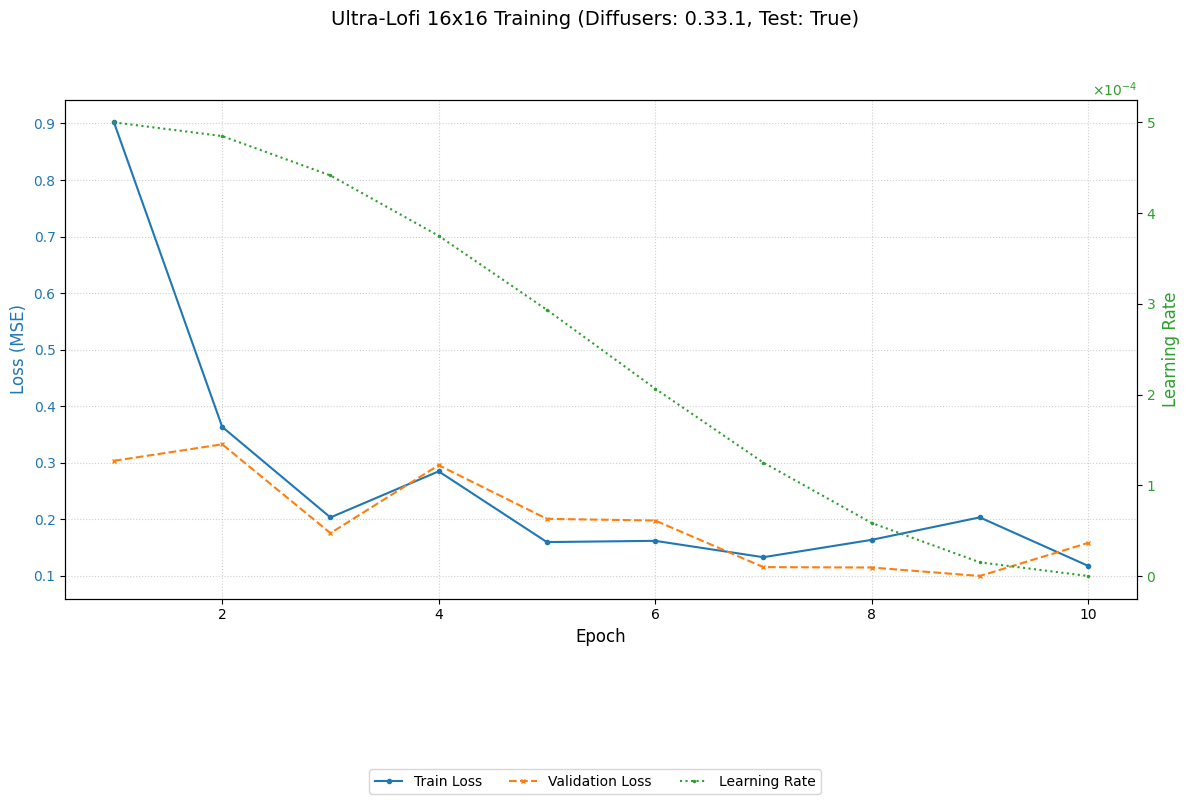

emergent metrics plot saved to /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/visualizations/emergent_metrics_testmode.png


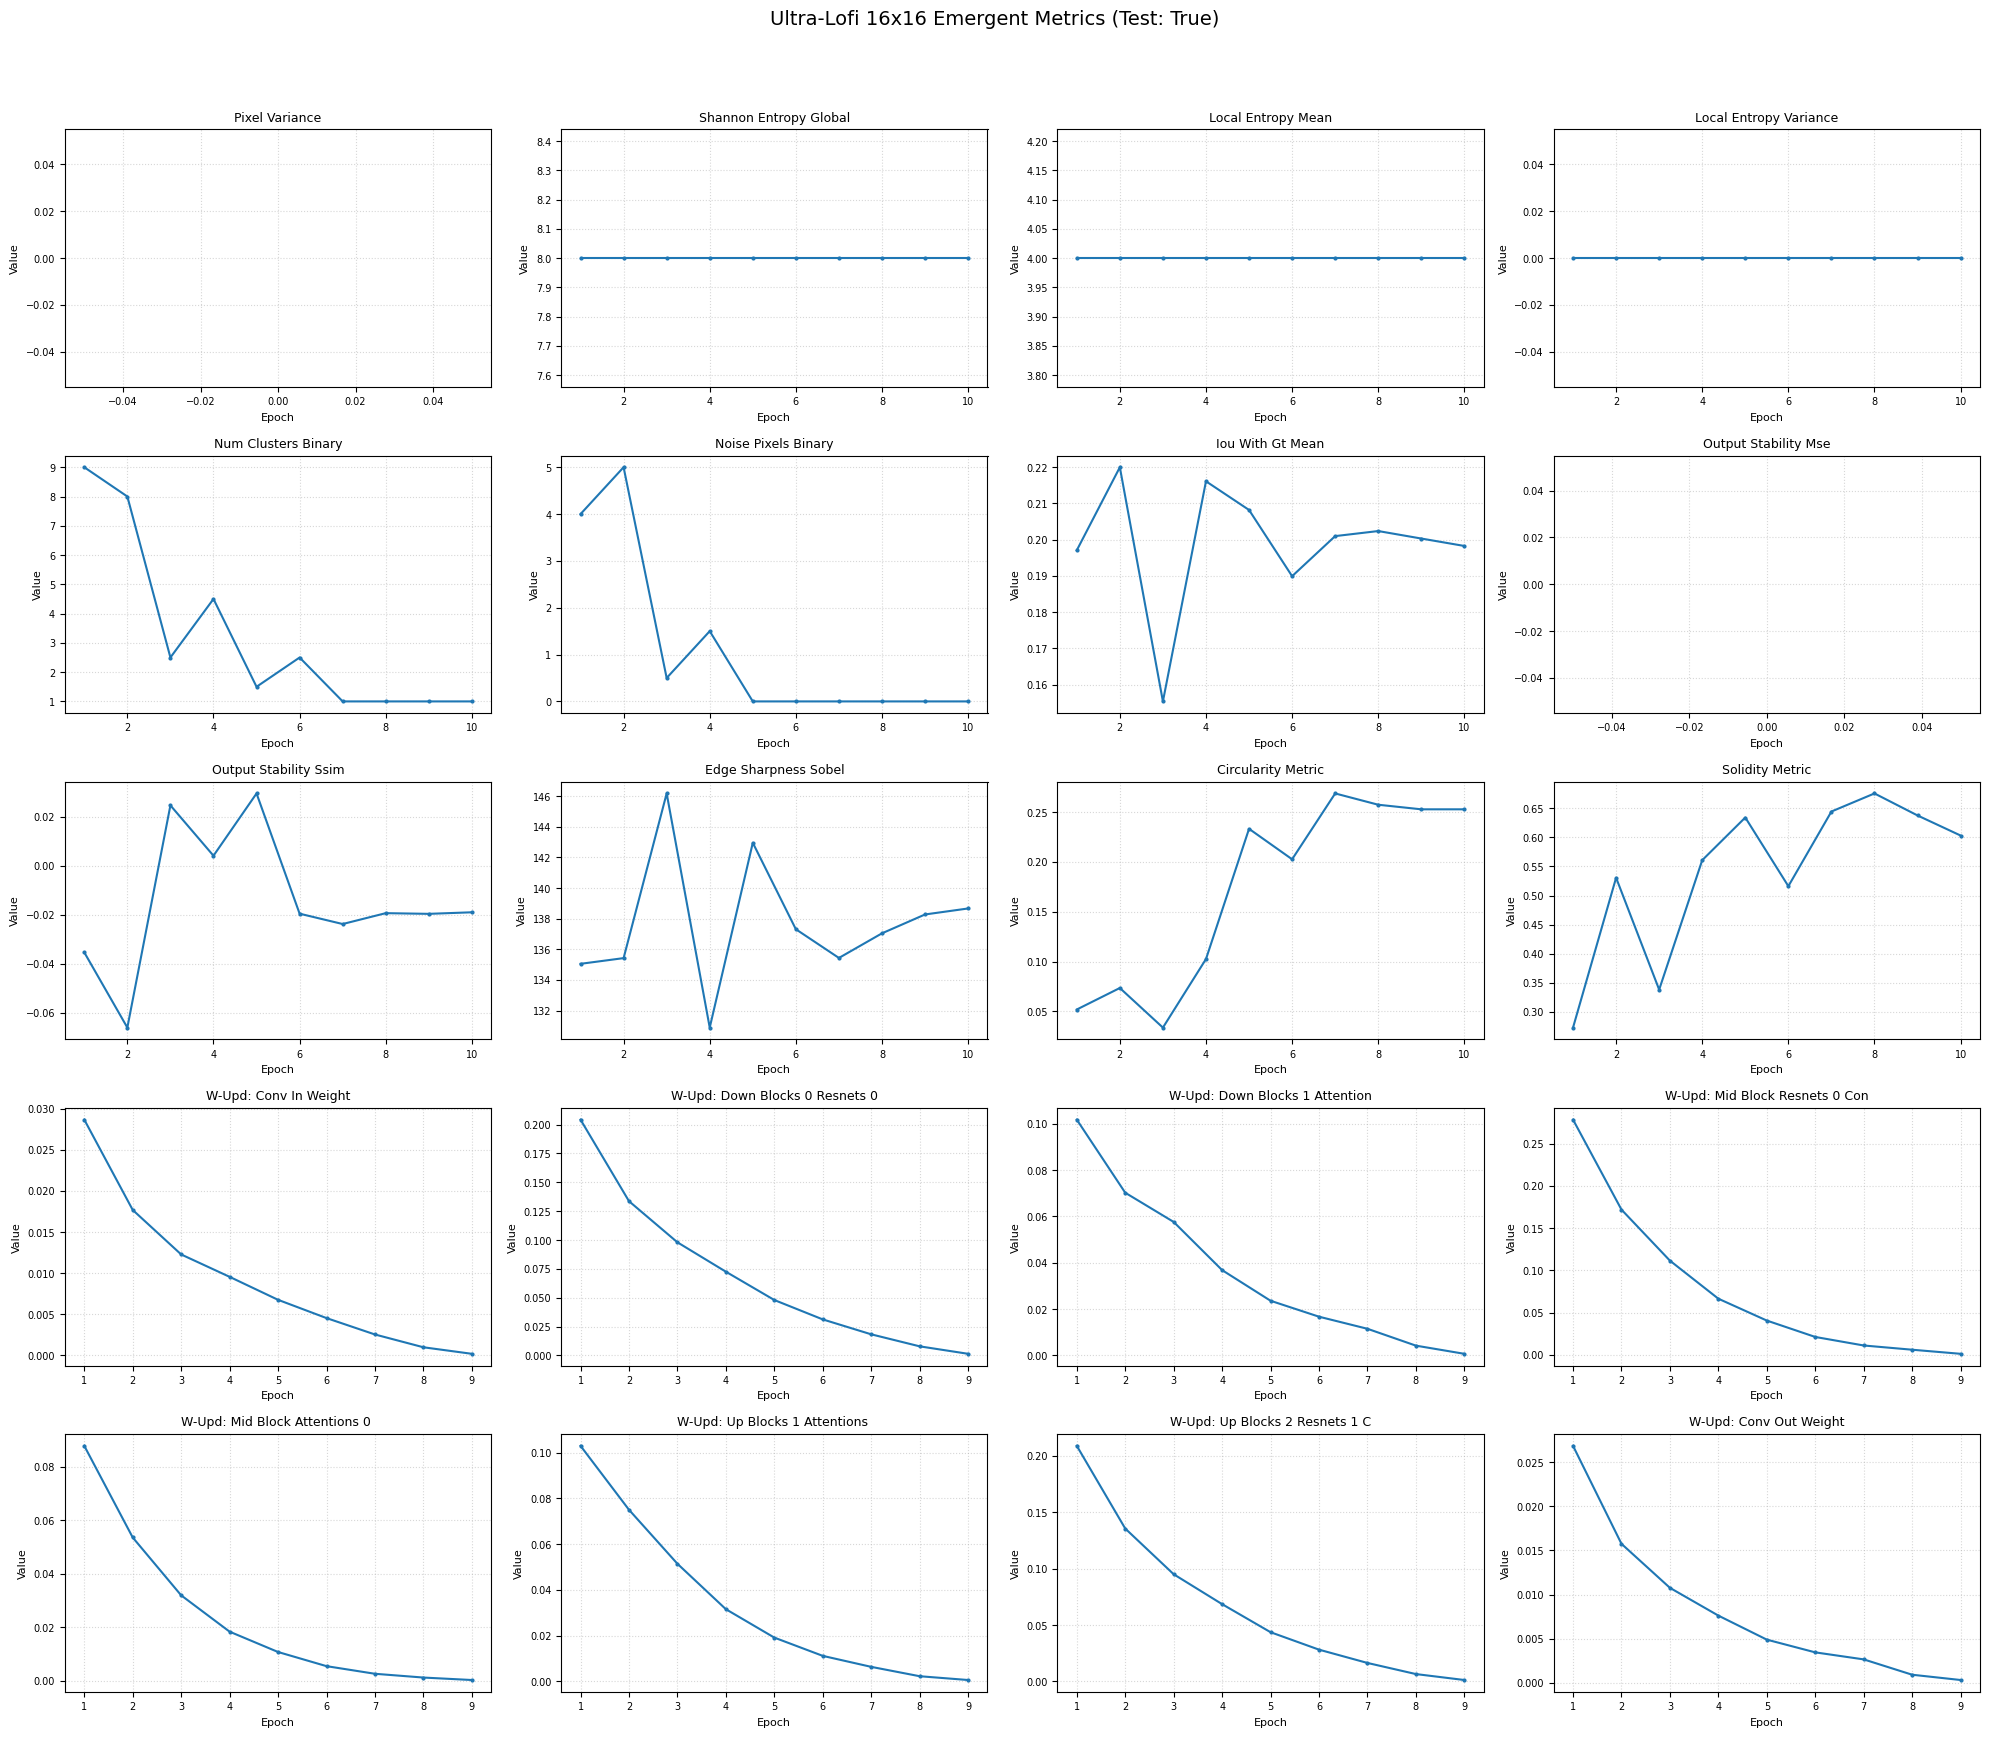


--- cell 4 plotting complete (test_mode: True) ---


In [5]:
# cell 4: plot learning curves & emergent metrics

import json
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np


try:
    if 'get_ipython' not in globals() or get_ipython() is None:
        plt.switch_backend('Agg')
except Exception as e_backend:
    print(f"note: could not switch matplotlib backend: {e_backend}")



# --- 1. load training history ---
loaded_history_for_plotting = None
if 'training_history' in globals() and isinstance(training_history, dict) and training_history.get('epoch'):
    print("using 'training_history' from memory for plotting.")
    loaded_history_for_plotting = training_history
elif TRAINING_HISTORY_FILE.exists():
    print(f"loading training history from: {TRAINING_HISTORY_FILE}")
    try:
        with open(TRAINING_HISTORY_FILE, 'r') as f_hist_plot:
            loaded_history_for_plotting = json.load(f_hist_plot)
        print("training history loaded successfully from file for plotting.")
    except Exception as e_load_plot:
        print(f"error: failed to load/parse training history from file: {e_load_plot}")
else:
    print(f"error: training history file not found at {TRAINING_HISTORY_FILE} and not in memory.")

# --- 2. plotting logic ---
if loaded_history_for_plotting and loaded_history_for_plotting.get('epoch') and len(loaded_history_for_plotting['epoch']) > 0:
    epochs_recorded_plot = loaded_history_for_plotting['epoch']
    num_epochs_recorded_plot = len(epochs_recorded_plot)
    print(f"\nplotting learning curves & metrics for {num_epochs_recorded_plot} recorded epochs...")

    def get_plot_data(history_dict, key_name, expected_len, default_val=np.nan):
        data = history_dict.get(key_name)
        if data is None or len(data) != expected_len:
            if data is not None and len(data) < expected_len:
                 print(f"warning: data for '{key_name}' (len {len(data)}) shorter than expected ({expected_len}). padding with {default_val}.")
                 return list(data) + [default_val] * (expected_len - len(data))
            print(f"warning: data for '{key_name}' missing or length mismatch. using defaults ({default_val}).")
            return [default_val] * expected_len
        return [x if isinstance(x, (int, float)) else np.nan for x in data]

    # --- 2.1: plot main learning curves (loss & lr) ---
    fig_main_plot, ax1_main_plot = plt.subplots(figsize=(12, 7))
    title_main_plot = f'Ultra-Lofi 16x16 Training (Diffusers: {CURRENT_DIFFUSERS_VERSION_STR.replace("_",".")}, Test: {TEST_MODE})'

    color_train_loss = 'tab:blue'
    ax1_main_plot.set_xlabel('Epoch', fontsize=12)
    ax1_main_plot.set_ylabel('Loss (MSE)', color=color_train_loss, fontsize=12)
    train_loss_data = get_plot_data(loaded_history_for_plotting, 'train_loss', num_epochs_recorded_plot)
    val_loss_data = get_plot_data(loaded_history_for_plotting, 'val_loss', num_epochs_recorded_plot)
    ax1_main_plot.plot(epochs_recorded_plot, train_loss_data, color=color_train_loss, linestyle='-', marker='o', markersize=3, label='Train Loss')
    ax1_main_plot.plot(epochs_recorded_plot, val_loss_data, color='tab:orange', linestyle='--', marker='x', markersize=3, label='Validation Loss')
    ax1_main_plot.tick_params(axis='y', labelcolor=color_train_loss, labelsize=10)
    ax1_main_plot.tick_params(axis='x', labelsize=10)
    ax1_main_plot.grid(True, linestyle=':', alpha=0.6)

    ax2_main_plot = ax1_main_plot.twinx()
    color_lr_plot = 'tab:green'
    lr_data = get_plot_data(loaded_history_for_plotting, 'learning_rate', num_epochs_recorded_plot)
    ax2_main_plot.set_ylabel('Learning Rate', color=color_lr_plot, fontsize=12)
    ax2_main_plot.plot(epochs_recorded_plot, lr_data, color=color_lr_plot, linestyle=':', marker='.', markersize=3, label='Learning Rate')
    ax2_main_plot.tick_params(axis='y', labelcolor=color_lr_plot, labelsize=10)
    ax2_main_plot.ticklabel_format(style='sci', axis='y', scilimits=(-2,3), useMathText=True)

    # combined legend for both axes
    lines1, labels1 = ax1_main_plot.get_legend_handles_labels()
    lines2, labels2 = ax2_main_plot.get_legend_handles_labels()
    fig_main_plot.legend(lines1 + lines2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=3, fontsize=10)
    fig_main_plot.suptitle(title_main_plot, fontsize=14, y=0.98)
    fig_main_plot.tight_layout(rect=[0, 0.05, 1, 0.95])

    main_lc_fig_path_plot = VISUALIZATION_DIR / _FIGURE_SAVE_NAME_MAIN_PLOT
    try:
        plt.savefig(main_lc_fig_path_plot, bbox_inches='tight')
        print(f"main learning curve plot saved to {main_lc_fig_path_plot.resolve()}")
    except Exception as e_lc_save_plot: print(f"error saving main learning curve plot: {e_lc_save_plot}")
    plt.show()

    # --- 2.2: plot emergent metrics ---
    metric_keys_to_plot_actual = [key for key in EMERGENT_METRIC_KEYS if f'metric_{key}' in loaded_history_for_plotting]

    if metric_keys_to_plot_actual:
        num_metrics_plot = len(metric_keys_to_plot_actual)
        cols_plot = 3 if num_metrics_plot > 6 else 2 if num_metrics_plot > 1 else 1
        if num_metrics_plot > 9: cols_plot = 4
        rows_plot = (num_metrics_plot + cols_plot - 1) // cols_plot

        fig_metrics_plot, axes_metrics_plot = plt.subplots(rows_plot, cols_plot, figsize=(cols_plot * 5, rows_plot * 3.5), squeeze=False)
        axes_metrics_flat_plot = axes_metrics_plot.flatten()
        title_metrics_plot = f'Ultra-Lofi 16x16 Emergent Metrics (Test: {TEST_MODE})'

        for i, metric_key_base in enumerate(metric_keys_to_plot_actual):
            history_key = f'metric_{metric_key_base}'
            ax_curr = axes_metrics_flat_plot[i]
            metric_values = get_plot_data(loaded_history_for_plotting, history_key, num_epochs_recorded_plot)

            # a bit of specific handling for weight updates for the first epoch (can be NaN/0)
            if metric_key_base.startswith("w_update_") and num_epochs_recorded_plot > 0:
                if len(epochs_recorded_plot) > 1 and np.isnan(metric_values[0]):
                    ax_curr.plot(epochs_recorded_plot[1:], metric_values[1:], linestyle='-', marker='.', markersize=4, label=metric_key_base)
                else:
                    ax_curr.plot(epochs_recorded_plot, metric_values, linestyle='-', marker='.', markersize=4, label=metric_key_base)
            else:
                ax_curr.plot(epochs_recorded_plot, metric_values, linestyle='-', marker='.', markersize=4, label=metric_key_base)

            # make titles more readable
            display_title = metric_key_base.replace('metric_', '').replace('_', ' ').title()
            if metric_key_base.startswith("w_update_"):
                display_title = "W-Upd: " + metric_key_base.replace('w_update_', '').replace('_', ' ').title()

            ax_curr.set_title(display_title[:30], fontsize=9)
            ax_curr.set_xlabel('Epoch', fontsize=8)
            ax_curr.set_ylabel('Value', fontsize=8)
            ax_curr.tick_params(axis='both', which='major', labelsize=7)
            ax_curr.grid(True, linestyle=':', alpha=0.5)

        for j in range(num_metrics_plot, len(axes_metrics_flat_plot)):
            axes_metrics_flat_plot[j].set_visible(False)

        fig_metrics_plot.suptitle(title_metrics_plot, fontsize=14, y=0.99)
        fig_metrics_plot.tight_layout(rect=[0, 0, 1, 0.96])

        metrics_fig_path_plot = VISUALIZATION_DIR / _FIGURE_SAVE_NAME_METRICS_PLOT
        try:
            plt.savefig(metrics_fig_path_plot, bbox_inches='tight')
            print(f"emergent metrics plot saved to {metrics_fig_path_plot.resolve()}")
        except Exception as e_metrics_save_plot: print(f"error saving emergent metrics plot: {e_metrics_save_plot}")
        plt.show()
    else:
        print("no emergent metric keys (or their data) found in history for plotting.")
else:
    print("no valid training history found to plot, or history is empty.")

print(f"\n--- cell 4 plotting complete (test_mode: {TEST_MODE}) ---")

In [6]:
# cell 5: experiment results archiving & summary

import json
import pandas as pd
import shutil
from pathlib import Path
import time
import os

print(f"--- results archiving process (test_mode: {TEST_MODE}) ---")


# determine epochs completed and best val loss
if 'best_val_loss' in globals():
    _BEST_VAL_LOSS_ARCHIVE = best_val_loss
else: _BEST_VAL_LOSS_ARCHIVE = float('nan')

if 'epochs_recorded_plot' in globals():
    _EPOCHS_COMPLETED_ARCHIVE = epochs_recorded_plot[-1] if epochs_recorded_plot else 0
elif 'training_history' in globals() and training_history.get('epoch'):
    _EPOCHS_COMPLETED_ARCHIVE = training_history['epoch'][-1] if training_history['epoch'] else 0
else: _EPOCHS_COMPLETED_ARCHIVE = 0


_ARCHIVE_SUBDIR = BASE_SAVE_DIR / 'archives_experiment'
_ARCHIVE_SUBDIR.mkdir(parents=True, exist_ok=True)
_ARCHIVE_TIMESTAMP_STR = time.strftime("%Y%m%d_%H%M%S")
_ARCHIVE_NAME_BASE_STR = f"{_EXPERIMENT_TAG_NAME}{'_testmode' if TEST_MODE else ''}_{_ARCHIVE_TIMESTAMP_STR}"

print(f"  archive base name: {_ARCHIVE_NAME_BASE_STR}")
print(f"  archive will be saved in: {_ARCHIVE_SUBDIR.resolve()}")

# --- 1. load training history (if not in memory) ---
loaded_history_for_archive = None
if 'training_history' in globals() and isinstance(training_history, dict) and training_history.get('epoch'):
    print("using 'training_history' from memory for archiving.")
    loaded_history_for_archive = training_history
elif TRAINING_HISTORY_FILE.exists():
    print(f"loading training history from: {TRAINING_HISTORY_FILE}")
    try:
        with open(TRAINING_HISTORY_FILE, 'r') as f_hist_arch:
            loaded_history_for_archive = json.load(f_hist_arch)
        print("training history loaded from file for archiving.")
    except Exception as e_load_arch:
        print(f"error: failed to load training history for archiving: {e_load_arch}")
else:
    print(f"warning: training history file not found at {TRAINING_HISTORY_FILE} and not in memory.")

# --- 2. export training history to csv ---
csv_file_path_archive = None
if loaded_history_for_archive and loaded_history_for_archive.get('epoch'):
    try:
        max_len = len(loaded_history_for_archive['epoch'])
        df_data = {}
        for key, values in loaded_history_for_archive.items():
            if isinstance(values, list):
                if len(values) < max_len:
                    df_data[key] = values + [np.nan] * (max_len - len(values))
                else:
                    df_data[key] = values[:max_len]
            else:
                df_data[key] = [values] * max_len

        history_df_archive = pd.DataFrame(df_data)
        csv_file_path_archive = _ARCHIVE_SUBDIR / f"{_ARCHIVE_NAME_BASE_STR}_training_history.csv"
        history_df_archive.to_csv(csv_file_path_archive, index=False)
        print(f"training history exported to csv: {csv_file_path_archive.resolve()}")
    except Exception as e_csv_archive:
        print(f"error exporting training history to csv: {e_csv_archive}")
else:
    print("no training history available to export to csv.")

# --- 3. create a summary report file (markdown) ---
summary_content_list = [
    f"# Experiment Run Summary: {_EXPERIMENT_TAG_NAME}",
    f"\n**Timestamp:** {_ARCHIVE_TIMESTAMP_STR}",
    f"**Test Mode:** {TEST_MODE}",
    "\n## Configuration Overview",
    f"- **Base Save Directory:** `{BASE_SAVE_DIR.resolve()}`",
    f"- **Image Size:** `{IMAGE_SIZE}`",
    f"- **Rendering:** `{SHARPNESS_TARGET}`",
    f"- **Diffusers Version (str):** `{CURRENT_DIFFUSERS_VERSION_STR.replace('_','.') if DIFFUSERS_IMPORT_SUCCESS else 'Failed/Unknown'}`",
    f"- **Dataset Config File:** `{DATASET_CONFIG_FILE.resolve() if DATASET_CONFIG_FILE.exists() else 'Not found'}`",
    "\n## Training Outcome",
    f"- **Epochs Completed:** `{_EPOCHS_COMPLETED_ARCHIVE}`",
    f"- **Best Validation Loss:** {f'{_BEST_VAL_LOSS_ARCHIVE:.5f}' if isinstance(_BEST_VAL_LOSS_ARCHIVE, float) and not np.isnan(_BEST_VAL_LOSS_ARCHIVE) else 'N/A'}",
    f"- **Model Checkpoint:** `{MODEL_CHECKPOINT_FILE.resolve() if MODEL_CHECKPOINT_FILE.exists() else 'Not found'}`",
    f"- **Training History (JSON):** `{TRAINING_HISTORY_FILE.resolve() if TRAINING_HISTORY_FILE.exists() else 'Not found'}`",
    f"- **Training History (CSV):** `{csv_file_path_archive.resolve() if csv_file_path_archive and csv_file_path_archive.exists() else 'Not generated or not found'}`",
    "\n## Key Visualizations",
    f"- **Learning Curves Plot:** `{ (VISUALIZATION_DIR / _FIGURE_SAVE_NAME_MAIN_PLOT).resolve() if (VISUALIZATION_DIR / _FIGURE_SAVE_NAME_MAIN_PLOT).exists() else 'Not found'}`",
    f"- **Emergent Metrics Plot:** `{ (VISUALIZATION_DIR / _FIGURE_SAVE_NAME_METRICS_PLOT).resolve() if (VISUALIZATION_DIR / _FIGURE_SAVE_NAME_METRICS_PLOT).exists() else 'Not found'}`",
    f"- **Epoch Sample Visualizations:** In `{VISUALIZATION_DIR.resolve()}` (e.g., `epoch_XXX_samples.png`).",
    "\n## Emergent Metrics Tracked",
    f"{', '.join(EMERGENT_METRIC_KEYS) if EMERGENT_METRIC_KEYS else 'None'}",
    "\n## Notes",
    "(Add any manual notes about this specific run here if needed)",
    "\n---\nGenerated by Experiment Archiver Cell"
]
summary_report_content_md = "\n".join(summary_content_list)
summary_report_path_md = _ARCHIVE_SUBDIR / f"{_ARCHIVE_NAME_BASE_STR}_summary.md"
try:
    with open(summary_report_path_md, 'w') as f_summary_md: f_summary_md.write(summary_report_content_md)
    print(f"experiment summary report saved to: {summary_report_path_md.resolve()}")
except Exception as e_summary_md: print(f"error saving summary report: {e_summary_md}")

# --- 4. create a zip archive of key results ---
files_to_archive_map = {
    "dataset_config.yaml": DATASET_CONFIG_FILE,
    "training_history.json": TRAINING_HISTORY_FILE,
    "training_history.csv": csv_file_path_archive,
    "model_checkpoint.pth": MODEL_CHECKPOINT_FILE,
    "summary_report.md": summary_report_path_md,
    "plot_learning_curves.png": (VISUALIZATION_DIR / _FIGURE_SAVE_NAME_MAIN_PLOT),
    "plot_emergent_metrics.png": (VISUALIZATION_DIR / _FIGURE_SAVE_NAME_METRICS_PLOT),
}

latest_epoch_vis_file_path = None
if VISUALIZATION_DIR and VISUALIZATION_DIR.exists():
    vis_files = sorted([f for f in VISUALIZATION_DIR.glob(f"epoch_*_samples.png")], reverse=True)
    if vis_files:
        latest_epoch_vis_file_path = vis_files[0]
        files_to_archive_map[f"latest_epoch_samples_{latest_epoch_vis_file_path.name}"] = latest_epoch_vis_file_path

archive_zip_target_path = _ARCHIVE_SUBDIR / _ARCHIVE_NAME_BASE_STR
temp_archive_content_path = _ARCHIVE_SUBDIR / f"{_ARCHIVE_NAME_BASE_STR}_temp_contents"
temp_archive_content_path.mkdir(parents=True, exist_ok=True)

print("\npreparing files for archive...")
prepared_count = 0
for dest_filename_in_zip, source_path_obj in files_to_archive_map.items():
    if source_path_obj and Path(source_path_obj).exists():
        try:
            shutil.copy(Path(source_path_obj), temp_archive_content_path / dest_filename_in_zip)
            prepared_count +=1
        except Exception as e_copy_zip: print(f"  error copying {source_path_obj} for archive: {e_copy_zip}")
    elif source_path_obj: print(f"  warning: source file for '{dest_filename_in_zip}' ({source_path_obj}) not found.")

if prepared_count > 0:
    print(f"\ncreating zip archive: {archive_zip_target_path.with_suffix('.zip').resolve()}")
    try:
        shutil.make_archive(
            base_name=str(archive_zip_target_path),
            format='zip',
            root_dir=temp_archive_content_path.parent,
            base_dir=temp_archive_content_path.name
        )
        print("zip archive created successfully.")
        shutil.rmtree(temp_archive_content_path)
        print(f"temporary archive content directory '{temp_archive_content_path.name}' removed.")
    except Exception as e_zip_archive: print(f"error creating zip archive: {e_zip_archive}")
else:
    print("no files were successfully prepared. zip archive not created.")
    if temp_archive_content_path.exists(): shutil.rmtree(temp_archive_content_path)

print(f"\n--- cell 5 archiving process complete (test_mode: {TEST_MODE}) ---")

--- results archiving process (test_mode: True) ---
  archive base name: ultralofi_img16_aliased_diffusers_0_33_1_testmode_20250606_190158
  archive will be saved in: /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/archives_experiment
using 'training_history' from memory for archiving.
training history exported to csv: /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/archives_experiment/ultralofi_img16_aliased_diffusers_0_33_1_testmode_20250606_190158_training_history.csv
experiment summary report saved to: /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/archives_experiment/ultralofi_img16_aliased_diffusers_0_33_1_testmode_20250606_190158_summary.md

preparing files for archive...

creating zip archive: /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/archives_experiment/ultralofi_img16_aliased_diffusers_0_33_1_testmode_20

In [7]:
# cell 8: ultimate evolving pca heatmap & cluster story video generator

import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import re
import time
import json
import matplotlib
matplotlib.use('Agg') #
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gc

print(f"--- ultimate pca evolution video generator (test_mode: {TEST_MODE}) ---")


VIDEO_ENABLE_PCA_EVOLUTION = True
VIDEO_PCA_FILENAME_PREFIX = "UltraLofi_PCA_EvolutionStory"
VIDEO_PCA_WIDTH = 720
VIDEO_PCA_HEIGHT = 1280
VIDEO_PCA_FPS = 10.0
VIDEO_PCA_PAUSE_DURATION_SECONDS = 2.5

LAYOUT_PCA_EPOCH_IMG_RATIO = 0.38
LAYOUT_PCA_LC_CHART_RATIO = 0.28
LAYOUT_PCA_PCA_HEATMAP_RATIO = 0.34

# pca specific parameters
PCA_WINDOW_SIZE = 15 if not TEST_MODE else 7
PCA_NUM_COMPONENTS_TO_DISPLAY = 3

PCA_METRICS_TO_INCLUDE_KEYS = [
    'metric_shannon_entropy_global',
    'metric_local_entropy_variance',
    'metric_IoU_with_gt_mean',
    'metric_edge_sharpness_sobel',
    'metric_output_stability_ssim',
    f"metric_w_update_{ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'][0].replace('.', '_') if ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'] else 'conv_in_weight'}"
]
PCA_HEATMAP_DPI = 75
PCA_HEATMAP_BG_COLOR = 'white'
PCA_HEATMAP_GRID_COLOR = 'lightgray'
PCA_HEATMAP_ANNOT_FMT = ".2f"
PCA_HEATMAP_CMAP = "vlag"
PCA_HEATMAP_CENTER = 0
PCA_HEATMAP_LINEWIDTH = 0.5
PCA_HEATMAP_CBAR_SHRINK = 0.8
PCA_HEATMAP_TITLE = "PCA Loadings (Metric Contributions to PCs)"
PCA_HEATMAP_X_LABELS = [f"PC{i+1}" for i in range(PCA_NUM_COMPONENTS_TO_DISPLAY)]

EVENT_DETECTION_CONFIG_PCA_VID = {
    'metric_IoU_with_gt_mean':      {'goal': 'maximize', 'threshold_factor': 0.90, 'smoothing': 7, 'stability_win': 5, 'tolerance': 0.03, 'event_label': "High IoU"},
    'metric_output_stability_ssim': {'goal': 'maximize', 'threshold_factor': 0.95, 'smoothing': 10, 'stability_win': 7, 'tolerance': 0.02, 'event_label': "Stable Output"},
     f"metric_w_update_{ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'][0].replace('.', '_') if ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'] else 'conv_in_weight'}":
                                    {'goal': 'minimize', 'threshold_factor': 5, 'smoothing': 10, 'stability_win': 5, 'tolerance': 0.1, 'event_label': f"{ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'][0].split('.')[0] if ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'] else 'Layer1'} W-Upd Minimized"},
}

METRICS_CONFIG_FOR_EVENT_LABELS_PCA_VID = {
    'metric_IoU_with_gt_mean': {'label': "Mean IoU w/ GT"},
    'metric_output_stability_ssim': {'label': "Stability (SSIM)"},
    f"metric_w_update_{ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'][0].replace('.', '_') if ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'] else 'conv_in_weight'}":
                                   {'label': f"W-Upd: {ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'][0].split('.')[0] if ENHANCED_METRIC_CONFIG['tracked_layers_for_weights'] else 'Layer1'}"}
}

PAUSE_TEXT_FONT_PCA = cv2.FONT_HERSHEY_SIMPLEX; PAUSE_TEXT_SCALE_PCA = 0.7; PAUSE_TEXT_COLOR_PCA = (255,255,255)
PAUSE_TEXT_THICKNESS_PCA = 2; PAUSE_TEXT_BG_COLOR_PCA = (0,0,0); PAUSE_TEXT_BG_ALPHA_PCA = 0.7
PAUSE_TEXT_Y_POS_RATIO_PCA = 0.05; PAUSE_TEXT_PADDING_PCA = 10
LC_CHART_LINE_COLOR_PCA = (0,0,255); LC_CHART_LINE_THICKNESS_PCA = 2
LC_PLOT_CALIB_PCA = {'x_plot_start_rel': 60, 'plot_width_rel': VIDEO_PCA_WIDTH - 120,
                     'y_line_start_rel': 40, 'line_height_rel': int(VIDEO_PCA_HEIGHT * LAYOUT_PCA_LC_CHART_RATIO) - 70}



NUM_PCA_PAUSE_FRAMES = int(VIDEO_PCA_FPS * VIDEO_PCA_PAUSE_DURATION_SECONDS)
_VIDEO_TIMESTAMP_PCA = time.strftime("%Y%m%d_%H%M%S")
_VIDEO_FILENAME_PCA = f"{VIDEO_PCA_FILENAME_PREFIX}_{_EXPERIMENT_TAG_NAME}{'_testmode' if TEST_MODE else ''}_{_VIDEO_TIMESTAMP_PCA}.mp4"
_VIDEO_FULL_PATH_PCA = VIDEO_OUTPUT_DIR / _VIDEO_FILENAME_PCA

print(f"  PCA Evolution Video Output Path: {_VIDEO_FULL_PATH_PCA}")
_H_EPOCH_PCA = int(VIDEO_PCA_HEIGHT * LAYOUT_PCA_EPOCH_IMG_RATIO)
_H_LC_CHART_PCA = int(VIDEO_PCA_HEIGHT * LAYOUT_PCA_LC_CHART_RATIO)
_H_PCA_HEATMAP_PCA = VIDEO_PCA_HEIGHT - _H_EPOCH_PCA - _H_LC_CHART_PCA
print(f"  Layout (H_px): EpochImg:{_H_EPOCH_PCA}, LCChart:{_H_LC_CHART_PCA}, PCAHeatmap:{_H_PCA_HEATMAP_PCA}")


def get_pca_loadings_with_alignment(data_window_standardized_df, n_components, prev_loadings_matrix=None):
    if data_window_standardized_df.shape[0] < n_components or data_window_standardized_df.shape[0] < PCA_WINDOW_SIZE / 2 :
        return None, None

    pca = PCA(n_components=n_components, svd_solver='full')
    try:
        pca.fit(data_window_standardized_df)
    except ValueError:
        return None, None

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_df = pd.DataFrame(loadings, index=data_window_standardized_df.columns, columns=[f"PC{i+1}" for i in range(n_components)])

    if prev_loadings_matrix is not None and prev_loadings_matrix.shape == loadings_df.shape:
        for col in loadings_df.columns:
            if np.sign(loadings_df[col].iloc[np.argmax(np.abs(loadings_df[col]))]) != \
               np.sign(prev_loadings_matrix[col].iloc[np.argmax(np.abs(prev_loadings_matrix[col]))]):
                if (prev_loadings_matrix[col] @ loadings_df[col]) < 0:
                     loadings_df[col] *= -1
    else:
        for col in loadings_df.columns:
            if loadings_df[col].iloc[np.argmax(np.abs(loadings_df[col]))] < 0:
                loadings_df[col] *= -1

    return loadings_df, pca.explained_variance_ratio_

def detect_metric_trigger_events_video_pca(history_dict, full_event_config, selected_metrics_config):
    if not history_dict or not history_dict.get('epoch'): return []
    num_epochs = len(history_dict['epoch'])
    detected_events = []
    for metric_key_hist, config in full_event_config.items():
        if metric_key_hist not in selected_metrics_config: continue
        metric_values = history_dict.get(metric_key_hist)
        if not metric_values or len(metric_values) != num_epochs: continue
        series = pd.Series(metric_values).fillna(method='bfill').fillna(method='ffill')
        if series.isna().any() or len(series) < config['smoothing'] or len(series) < config['stability_win']: continue
        smoothed = series.rolling(window=config['smoothing'],center=True,min_periods=1).mean().fillna(method='bfill').fillna(method='ffill')
        if smoothed.isna().any():
            first_valid_idx = smoothed.first_valid_index()
            if first_valid_idx is not None and first_valid_idx > 0: smoothed.iloc[:first_valid_idx] = smoothed.iloc[first_valid_idx]
        trigger_idx = -1
        if config['goal'] == 'maximize':
            target = smoothed.max() * config.get('threshold_factor',0.95)
            for i in range(num_epochs - config['stability_win']):
                if smoothed.iloc[i] >= target:
                    if (smoothed.iloc[i : i + config['stability_win']] >= target * (1-config['tolerance'])).all(): trigger_idx=i; break
        elif config['goal'] == 'minimize':
            override = config.get('target_val_override')
            target_abs = override if override is not None else (smoothed.min() * config.get('threshold_factor',1.05))
            tol_abs = abs(target_abs * config['tolerance']) if target_abs != 0 else config['tolerance']
            for i in range(num_epochs - config['stability_win']):
                if abs(smoothed.iloc[i] - target_abs) <= tol_abs:
                    if (abs(smoothed.iloc[i : i + config['stability_win']] - target_abs) <= tol_abs).all(): trigger_idx=i; break
        elif config['goal'] == 'stabilize':
            stabilization_thresh = smoothed.std() * config['tolerance'] if smoothed.std() > 1e-6 else config['tolerance'] * 0.01
            for i in range(config['smoothing'], num_epochs - config['stability_win']):
                if smoothed.iloc[i : i + config['stability_win']].std() < stabilization_thresh : trigger_idx=i; break
        if trigger_idx != -1:
            detected_events.append({'metric_key': metric_key_hist, 'display_name': config.get('event_label', selected_metrics_config[metric_key_hist]['label']),
                                    'trigger_epoch_idx': trigger_idx, 'trigger_epoch_num': history_dict['epoch'][trigger_idx]})
    return sorted(detected_events, key=lambda e: e['trigger_epoch_idx'])


CAN_RUN_PCA_VIDEO = True if VIDEO_ENABLE_PCA_EVOLUTION else False
_HISTORY_DATA_PCA = None
if CAN_RUN_PCA_VIDEO:
    if 'training_history' in globals() and training_history.get('epoch'): _HISTORY_DATA_PCA = training_history
    elif TRAINING_HISTORY_FILE.exists():
        try:
            with open(TRAINING_HISTORY_FILE, 'r') as f: _HISTORY_DATA_PCA = json.load(f)
            print(f"loaded history from: {TRAINING_HISTORY_FILE}")
        except Exception as e: print(f"error loading history: {e}"); CAN_RUN_PCA_VIDEO = False
    else: print(f"error: training history not found."); CAN_RUN_PCA_VIDEO = False

_PCA_METRICS_DF_SCALED = None
if CAN_RUN_PCA_VIDEO and _HISTORY_DATA_PCA:
    pca_data_dict = {}
    num_epochs_total = len(_HISTORY_DATA_PCA['epoch'])
    valid_pca_metric_keys = []
    for key in PCA_METRICS_TO_INCLUDE_KEYS:
        if key in _HISTORY_DATA_PCA and isinstance(_HISTORY_DATA_PCA[key], list) and len(_HISTORY_DATA_PCA[key]) == num_epochs_total:
            pca_data_dict[key.replace('metric_', '')] = _HISTORY_DATA_PCA[key]
            valid_pca_metric_keys.append(key.replace('metric_', ''))
        else: print(f"warning: metric '{key}' for PCA not found or length mismatch in history. skipping for pca.")

    if len(pca_data_dict) < PCA_NUM_COMPONENTS_TO_DISPLAY or len(pca_data_dict) < 2:
        print(f"error: not enough valid metrics ({len(pca_data_dict)}) for PCA (need >= {max(2,PCA_NUM_COMPONENTS_TO_DISPLAY)}). cannot generate pca video.")
        CAN_RUN_PCA_VIDEO = False
    else:
        _pca_metrics_df_raw = pd.DataFrame(pca_data_dict)
        _pca_metrics_df_filled = _pca_metrics_df_raw.fillna(method='ffill').fillna(method='bfill')
        if _pca_metrics_df_filled.isnull().any().any():
             _pca_metrics_df_filled.fillna(0, inplace=True)

        scaler = StandardScaler()
        _PCA_METRICS_DF_SCALED = pd.DataFrame(scaler.fit_transform(_pca_metrics_df_filled), columns=_pca_metrics_df_filled.columns)
        print(f"data prepared for PCA with {_PCA_METRICS_DF_SCALED.shape[1]} features.")
        PCA_METRIC_YLABELS_ACTUAL = [name.replace('_', ' ').title()[:20] for name in _PCA_METRICS_DF_SCALED.columns]


_TRIGGER_EVENTS_LIST_PCA = []
if CAN_RUN_PCA_VIDEO and _HISTORY_DATA_PCA:
    _TRIGGER_EVENTS_LIST_PCA = detect_metric_trigger_events_video_pca(_HISTORY_DATA_PCA, EVENT_DETECTION_CONFIG_PCA_VID, METRICS_CONFIG_FOR_EVENT_LABELS_PCA_VID)
    if not _TRIGGER_EVENTS_LIST_PCA: print("no metric trigger events for pause detected.")
    else: print(f"detected {len(_TRIGGER_EVENTS_LIST_PCA)} metric trigger events for pause.")


# --- 4. Load Static LC Chart & Epoch Images ---
_LC_CHART_FINAL_PCA, _EPOCH_IMAGE_PATHS_PCA, _NUM_FRAMES_PCA = None, [], 0
if CAN_RUN_PCA_VIDEO:
    lc_path_pca = VISUALIZATION_DIR / _FIGURE_SAVE_NAME_MAIN_PLOT
    if lc_path_pca.exists():
        lc_orig_pca = cv2.imread(str(lc_path_pca)); _LC_CHART_FINAL_PCA = cv2.resize(lc_orig_pca, (VIDEO_PCA_WIDTH, _H_LC_CHART_PCA), cv2.INTER_AREA) if lc_orig_pca is not None else None
    if _LC_CHART_FINAL_PCA is None: print(f"error: LC chart image load/resize failed."); CAN_RUN_PCA_VIDEO = False

    img_pattern_pca = f"epoch_*_samples.png"
    def get_epoch_idx_pca(p): match = re.search(r"epoch_(\d+)_samples",p.name); return int(match.group(1))-1 if match else -1
    raw_paths_pca = [p for p in VISUALIZATION_DIR.glob(img_pattern_pca) if get_epoch_idx_pca(p) != -1]
    _EPOCH_IMAGE_PATHS_PCA = sorted(raw_paths_pca, key=get_epoch_idx_pca)
    _NUM_FRAMES_PCA = len(_EPOCH_IMAGE_PATHS_PCA)
    if _NUM_FRAMES_PCA == 0: print(f"error: no epoch images found."); CAN_RUN_PCA_VIDEO = False
    elif _HISTORY_DATA_PCA and len(_HISTORY_DATA_PCA.get('epoch',[])) != _NUM_FRAMES_PCA:
        print(f"warning: epoch img count ({_NUM_FRAMES_PCA}) != history epochs ({len(_HISTORY_DATA_PCA.get('epoch',[]))}). Adjusting PCA data length if necessary.")
        if _PCA_METRICS_DF_SCALED is not None and len(_PCA_METRICS_DF_SCALED) > _NUM_FRAMES_PCA:
            _PCA_METRICS_DF_SCALED = _PCA_METRICS_DF_SCALED.iloc[:_NUM_FRAMES_PCA]
            print(f"  PCA data truncated to {_NUM_FRAMES_PCA} rows to match image count.")


# --- 5. Initialize VideoWriter ---
_VIDEO_WRITER_PCA = None
if CAN_RUN_PCA_VIDEO and _NUM_FRAMES_PCA > 0:
    _VIDEO_WRITER_PCA = cv2.VideoWriter(str(_VIDEO_FULL_PATH_PCA), cv2.VideoWriter_fourcc(*'mp4v'), VIDEO_PCA_FPS, (VIDEO_PCA_WIDTH, VIDEO_PCA_HEIGHT))
    if not _VIDEO_WRITER_PCA.isOpened(): print(f"error: could not open VideoWriter."); CAN_RUN_PCA_VIDEO = False

# --- 6. Main Video Generation Loop ---
if CAN_RUN_PCA_VIDEO and _NUM_FRAMES_PCA > 0 and _VIDEO_WRITER_PCA and _VIDEO_WRITER_PCA.isOpened() and _PCA_METRICS_DF_SCALED is not None:
    print(f"\nstarting PCA evolution video generation for {_NUM_FRAMES_PCA} frames...")
    _processed_pause_events_pca = set()
    fig_w_pca, fig_h_pca = VIDEO_PCA_WIDTH / PCA_HEATMAP_DPI, _H_PCA_HEATMAP_PCA / PCA_HEATMAP_DPI
    _previous_loadings_for_alignment = None

    for frame_idx in range(_NUM_FRAMES_PCA):

        epoch_img_pca = cv2.imread(str(_EPOCH_IMAGE_PATHS_PCA[frame_idx]))
        epoch_final_img_pca = cv2.resize(epoch_img_pca, (VIDEO_PCA_WIDTH, _H_EPOCH_PCA), cv2.INTER_AREA) if epoch_img_pca is not None else np.zeros((_H_EPOCH_PCA, VIDEO_PCA_WIDTH, 3),dtype=np.uint8)


        pca_heatmap_img = np.full((_H_PCA_HEATMAP_PCA, VIDEO_PCA_WIDTH, 3), 240, dtype=np.uint8)


        if frame_idx < len(_PCA_METRICS_DF_SCALED) :
            current_window_data = _PCA_METRICS_DF_SCALED.iloc[max(0, frame_idx - PCA_WINDOW_SIZE + 1) : frame_idx + 1]

            if not current_window_data.empty and current_window_data.shape[0] >= max(2,PCA_NUM_COMPONENTS_TO_DISPLAY) :
                loadings_df, explained_variance = get_pca_loadings_with_alignment(current_window_data, PCA_NUM_COMPONENTS_TO_DISPLAY, _previous_loadings_for_alignment)
                if loadings_df is not None:
                    _previous_loadings_for_alignment = loadings_df.copy()
                    fig_pca, ax_pca = plt.subplots(figsize=(fig_w_pca, fig_h_pca), dpi=PCA_HEATMAP_DPI)
                    fig_pca.patch.set_facecolor(PCA_HEATMAP_BG_COLOR); ax_pca.set_facecolor(PCA_HEATMAP_BG_COLOR)
                    sns.heatmap(loadings_df, ax=ax_pca, annot=True, fmt=PCA_HEATMAP_ANNOT_FMT, cmap=PCA_HEATMAP_CMAP, center=PCA_HEATMAP_CENTER,
                                linewidths=PCA_HEATMAP_LINEWIDTH, cbar_kws={"shrink": PCA_HEATMAP_CBAR_SHRINK}, yticklabels=PCA_METRIC_YLABELS_ACTUAL)
                    pc_x_labels_with_variance = [f"{PCA_HEATMAP_X_LABELS[i]}\n({explained_variance[i]*100:.1f}%)" for i in range(len(explained_variance))]
                    ax_pca.set_xticklabels(pc_x_labels_with_variance, rotation=0, fontsize=7)
                    ax_pca.tick_params(axis='y', rotation=0, labelsize=7)
                    ax_pca.set_title(PCA_HEATMAP_TITLE, fontsize=9)
                    plt.tight_layout(pad=0.5)
                    fig_pca.canvas.draw()
                    pca_heatmap_img_rendered = cv2.cvtColor(np.array(fig_pca.canvas.buffer_rgba()), cv2.COLOR_RGBA2BGR)
                    if pca_heatmap_img_rendered.shape[0] != _H_PCA_HEATMAP_PCA or pca_heatmap_img_rendered.shape[1] != VIDEO_PCA_WIDTH:
                        pca_heatmap_img = cv2.resize(pca_heatmap_img_rendered, (VIDEO_PCA_WIDTH, _H_PCA_HEATMAP_PCA), interpolation=cv2.INTER_AREA)
                    else: pca_heatmap_img = pca_heatmap_img_rendered
                    plt.close(fig_pca);
                else:
                    cv2.putText(pca_heatmap_img, "PCA Priming...", (50, _H_PCA_HEATMAP_PCA//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
            else:
                 cv2.putText(pca_heatmap_img, f"PCA: {frame_idx+1}/{PCA_WINDOW_SIZE} epochs", (30, _H_PCA_HEATMAP_PCA//2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (100,100,100), 2)
        else:
            cv2.putText(pca_heatmap_img, "PCA Data Unavailable", (50, _H_PCA_HEATMAP_PCA//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)


        # c. composite frame
        base_frame_pca = np.zeros((VIDEO_PCA_HEIGHT, VIDEO_PCA_WIDTH, 3), dtype=np.uint8)
        y_off_pca = 0
        base_frame_pca[y_off_pca : y_off_pca + _H_EPOCH_PCA, :] = epoch_final_img_pca; y_off_pca += _H_EPOCH_PCA
        if _LC_CHART_FINAL_PCA is not None: base_frame_pca[y_off_pca : y_off_pca + _H_LC_CHART_PCA, :] = _LC_CHART_FINAL_PCA
        y_off_lc_start_pca = y_off_pca; y_off_pca += _H_LC_CHART_PCA
        base_frame_pca[y_off_pca : y_off_pca + _H_PCA_HEATMAP_PCA, :] = pca_heatmap_img

        # lc chart progress line
        if _LC_CHART_FINAL_PCA is not None:
            lc_prog_ratio_pca = frame_idx / (_NUM_FRAMES_PCA - 1) if _NUM_FRAMES_PCA > 1 else 0.0
            lx_lc = LC_PLOT_CALIB_PCA['x_plot_start_rel'] + int(lc_prog_ratio_pca * LC_PLOT_CALIB_PCA['plot_width_rel'])
            lx_lc = max(LC_PLOT_CALIB_PCA['x_plot_start_rel'], min(lx_lc, LC_PLOT_CALIB_PCA['x_plot_start_rel'] + LC_PLOT_CALIB_PCA['plot_width_rel']))
            ly1, ly2 = y_off_lc_start_pca + LC_PLOT_CALIB_PCA['y_line_start_rel'], y_off_lc_start_pca + LC_PLOT_CALIB_PCA['y_line_start_rel'] + LC_PLOT_CALIB_PCA['line_height_rel']
            cv2.line(base_frame_pca, (lx_lc, ly1), (lx_lc, ly2), LC_CHART_LINE_COLOR_PCA, LC_CHART_LINE_THICKNESS_PCA)

        epoch_num_pca_disp = get_epoch_idx_pca(_EPOCH_IMAGE_PATHS_PCA[frame_idx]) + 1
        cv2.putText(base_frame_pca, f"Epoch: {epoch_num_pca_disp}", (15, _H_EPOCH_PCA-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (220,220,220),1,cv2.LINE_AA)

        # d. pause events
        pause_pca_frame, active_event_names_pca = False, []
        for evt_idx, evt_data in enumerate(_TRIGGER_EVENTS_LIST_PCA):
            if evt_data['trigger_epoch_idx'] == frame_idx and evt_idx not in _processed_pause_events_pca:
                pause_pca_frame = True; active_event_names_pca.append(evt_data['display_name']); _processed_pause_events_pca.add(evt_idx)

        if pause_pca_frame:
            pause_ann_pca = base_frame_pca.copy()
            pause_lbl_pca = f"EVENT: {', '.join(active_event_names_pca)} (Ep {epoch_num_pca_disp})"
            (ptxt_w,ptxt_h),p_bline = cv2.getTextSize(pause_lbl_pca,PAUSE_TEXT_FONT_PCA,PAUSE_TEXT_SCALE_PCA,PAUSE_TEXT_THICKNESS_PCA)
            pb_h = ptxt_h+p_bline+2*PAUSE_TEXT_PADDING_PCA
            pb_y = int(VIDEO_PCA_HEIGHT*PAUSE_TEXT_Y_POS_RATIO_PCA) - int(pb_h/2)
            pb_x = int((VIDEO_PCA_WIDTH-(ptxt_w+2*PAUSE_TEXT_PADDING_PCA))/2)
            ptxt_x, ptxt_y = pb_x+PAUSE_TEXT_PADDING_PCA, pb_y+PAUSE_TEXT_PADDING_PCA+ptxt_h

            pb_overlay = pause_ann_pca.copy()
            cv2.rectangle(pb_overlay,(pb_x,pb_y),(pb_x+ptxt_w+2*PAUSE_TEXT_PADDING_PCA,pb_y+pb_h),PAUSE_TEXT_BG_COLOR_PCA,-1)
            cv2.addWeighted(pb_overlay,PAUSE_TEXT_BG_ALPHA_PCA,pause_ann_pca,1-PAUSE_TEXT_BG_ALPHA_PCA,0,pause_ann_pca)
            cv2.putText(pause_ann_pca,pause_lbl_pca,(ptxt_x,ptxt_y),PAUSE_TEXT_FONT_PCA,PAUSE_TEXT_SCALE_PCA,PAUSE_TEXT_COLOR_PCA,PAUSE_TEXT_THICKNESS_PCA,cv2.LINE_AA)
            for _ in range(NUM_PCA_PAUSE_FRAMES): _VIDEO_WRITER_PCA.write(pause_ann_pca)
        else:
            _VIDEO_WRITER_PCA.write(base_frame_pca)

        if frame_idx % 50 == 0: gc.collect()

    print("pca evolution video generation loop complete.")

# --- 7. Finalize ---
if _VIDEO_WRITER_PCA is not None and _VIDEO_WRITER_PCA.isOpened():
    _VIDEO_WRITER_PCA.release(); print(f"pca evolution video saved successfully to: {_VIDEO_FULL_PATH_PCA.resolve()}")
elif CAN_RUN_PCA_VIDEO and _NUM_FRAMES_PCA > 0: print("video writer not open/init. video not saved.")
else: print("pca video generation skipped due to errors or no frames.")

print(f"\n--- cell 8 pca evolution video generator complete (test_mode: {TEST_MODE}) ---")

--- ultimate pca evolution video generator (test_mode: True) ---
  PCA Evolution Video Output Path: drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/videos_ultimate/UltraLofi_PCA_EvolutionStory_ultralofi_img16_aliased_diffusers_0_33_1_testmode_20250606_190200.mp4
  Layout (H_px): EpochImg:486, LCChart:358, PCAHeatmap:436
data prepared for PCA with 5 features.
detected 1 metric trigger events for pause.

starting PCA evolution video generation for 10 frames...


<ipython-input-7-b673417c1036>:180: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  _pca_metrics_df_filled = _pca_metrics_df_raw.fillna(method='ffill').fillna(method='bfill')
<ipython-input-7-b673417c1036>:124: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = pd.Series(metric_values).fillna(method='bfill').fillna(method='ffill')
<ipython-input-7-b673417c1036>:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed = series.rolling(window=config['smoothing'],center=True,min_periods=1).mean().fillna(method='bfill').fillna(method='ffill')


pca evolution video generation loop complete.
pca evolution video saved successfully to: /content/drive/MyDrive/diffusion_tests/run_img16_aliased_diffusers_0_33_1_20250606_185955/videos_ultimate/UltraLofi_PCA_EvolutionStory_ultralofi_img16_aliased_diffusers_0_33_1_testmode_20250606_190200.mp4

--- cell 8 pca evolution video generator complete (test_mode: True) ---
